<a href="https://colab.research.google.com/github/eesh03/BCS_Introductory_Comp_Neuro/blob/main/modelling_eesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# @title Figure Settings
import ipywidgets as widgets #interactive display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
# @title Plotting functions

def plot_isis(single_neuron_isis):
  plt.hist(single_neuron_isis, bins=50, histtype="stepfilled")
  plt.axvline(single_neuron_isis.mean(), color="orange", label="Mean ISI")
  plt.xlabel("ISI duration (s)")
  plt.ylabel("Number of spikes")
  plt.legend()

In [4]:
#@title Data retrieval
#@markdown This cell downloads the example dataset that we will use in this tutorial.
import io
import requests
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
  print('Failed to download data')
else:
  spike_times = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']

In [5]:
type(spike_times)

numpy.ndarray

In [6]:
spike_times.shape

(734,)

In [7]:
idx = 0
print(
  type(spike_times[idx]),
  spike_times[idx].shape,
  sep="\n",
)

<class 'numpy.ndarray'>
(826,)


In [8]:
i_neurons = [0, 321]
i_print = slice(0, 5)

for i in i_neurons:
  print(
    "Neuron {}:".format(i),
    spike_times[i].dtype,
    spike_times[i][i_print],
    "\n",
    sep="\n"
  )

Neuron 0:
float32
[ 0.8149   14.822467 24.9646   25.1436   38.8709  ]


Neuron 321:
float32
[1.0698667 1.1536334 1.2403667 1.7072    1.799    ]




In [9]:
n_neurons = len(spike_times)
total_spikes_per_neuron = [len(spike_times_i) for spike_times_i in spike_times]

print(f"Number of neurons: {n_neurons}")
print(f"Number of spikes for first five neurons: {total_spikes_per_neuron[:5]}")

Number of neurons: 734
Number of spikes for first five neurons: [826, 2818, 3953, 646, 1115]


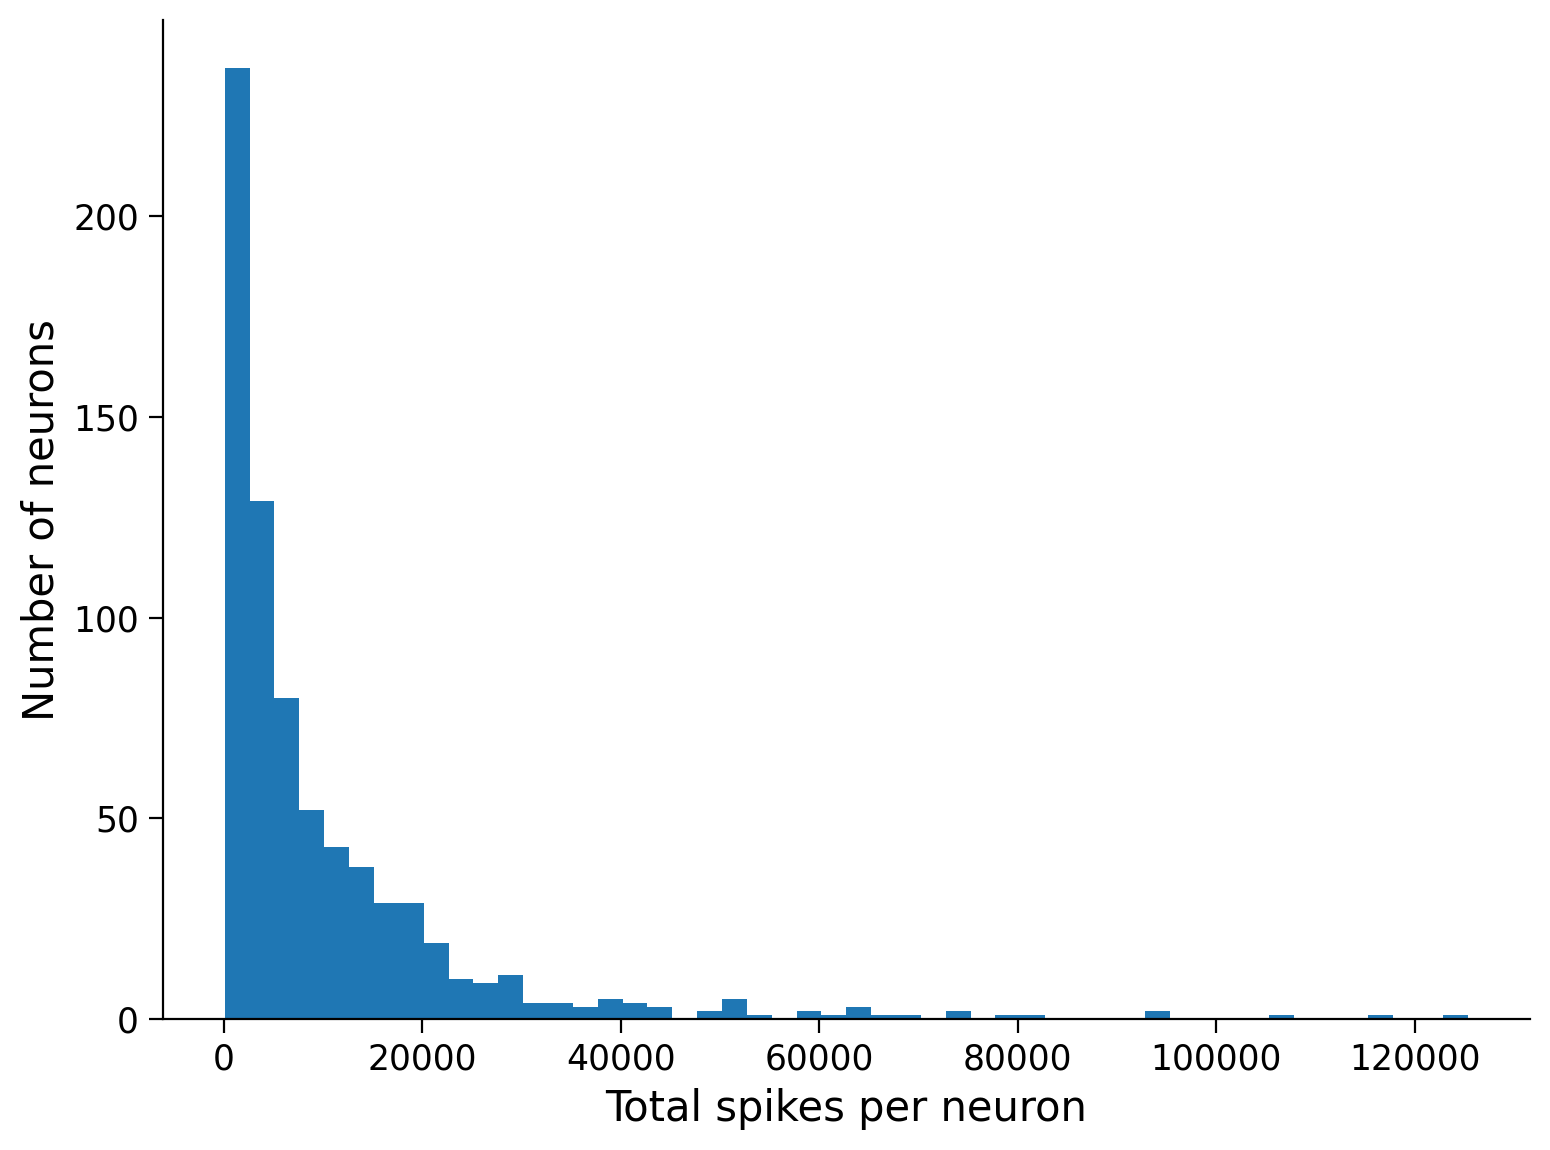

In [10]:
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons");

In [11]:
mean_spike_count = np.mean(total_spikes_per_neuron)
frac_below_mean = (total_spikes_per_neuron < mean_spike_count).mean()
print(f"{frac_below_mean:2.1%} of neurons are below the mean")

68.0% of neurons are below the mean


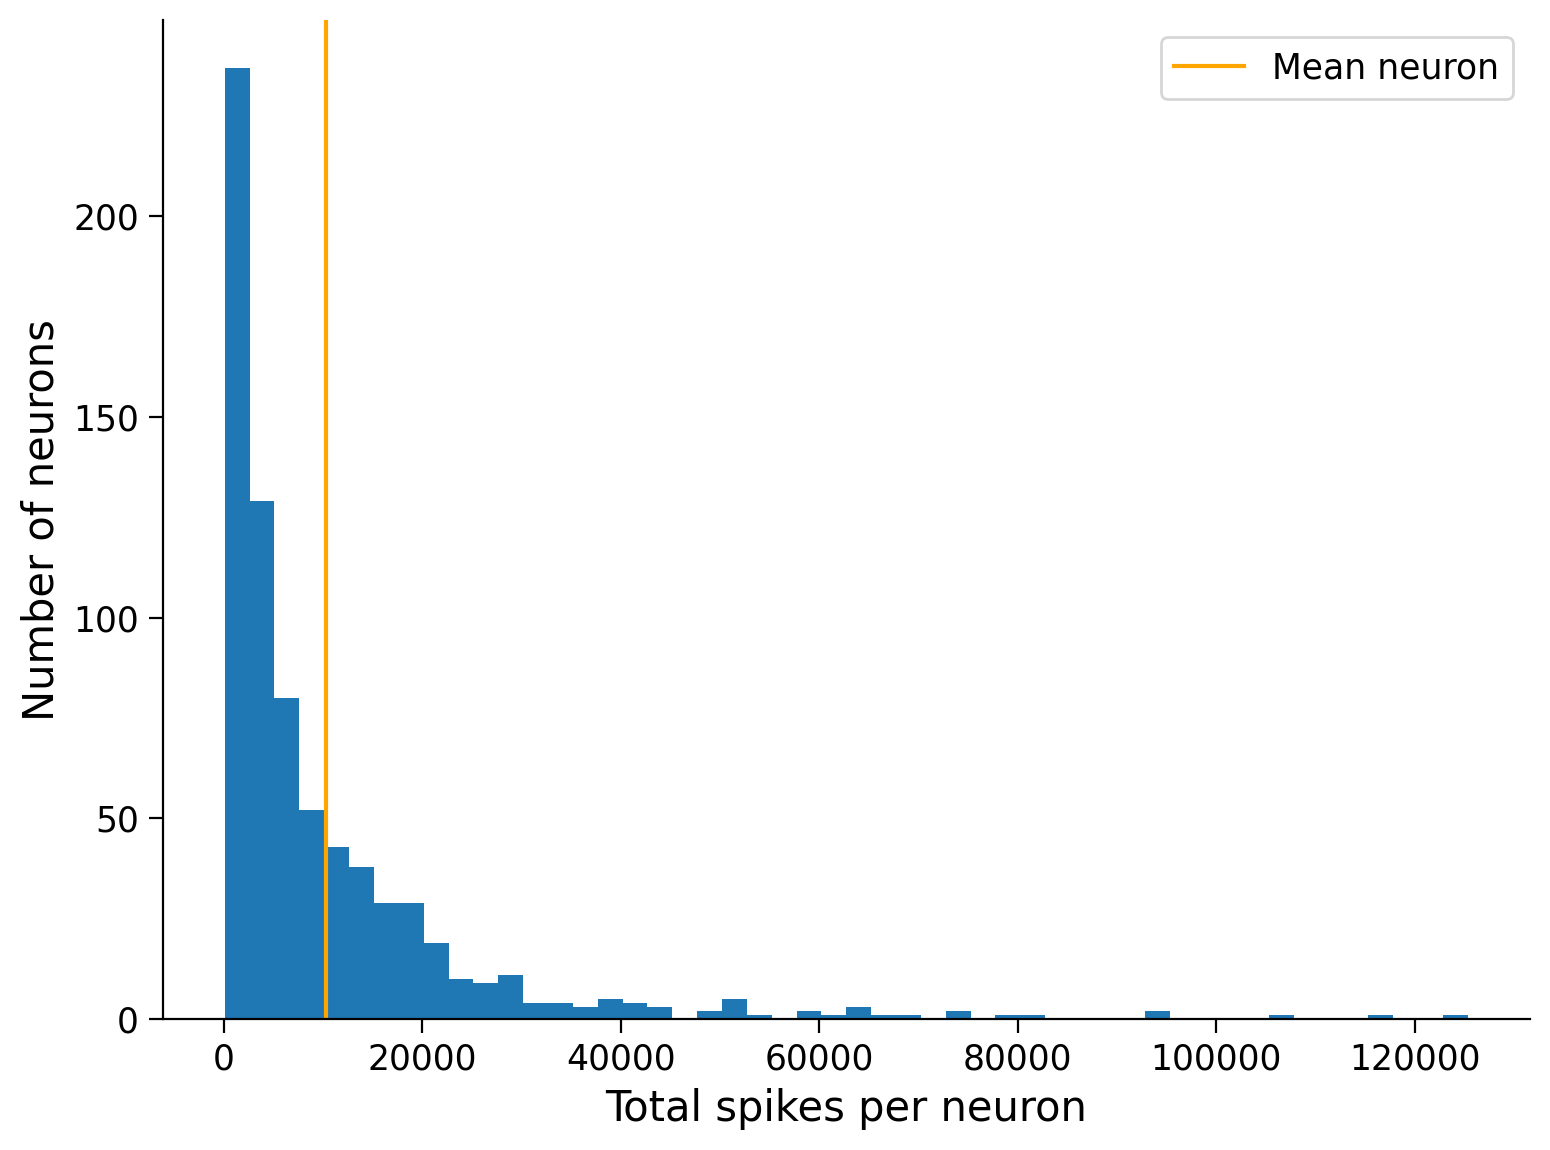

In [12]:
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.axvline(mean_spike_count, color="orange", label="Mean neuron")
plt.legend();

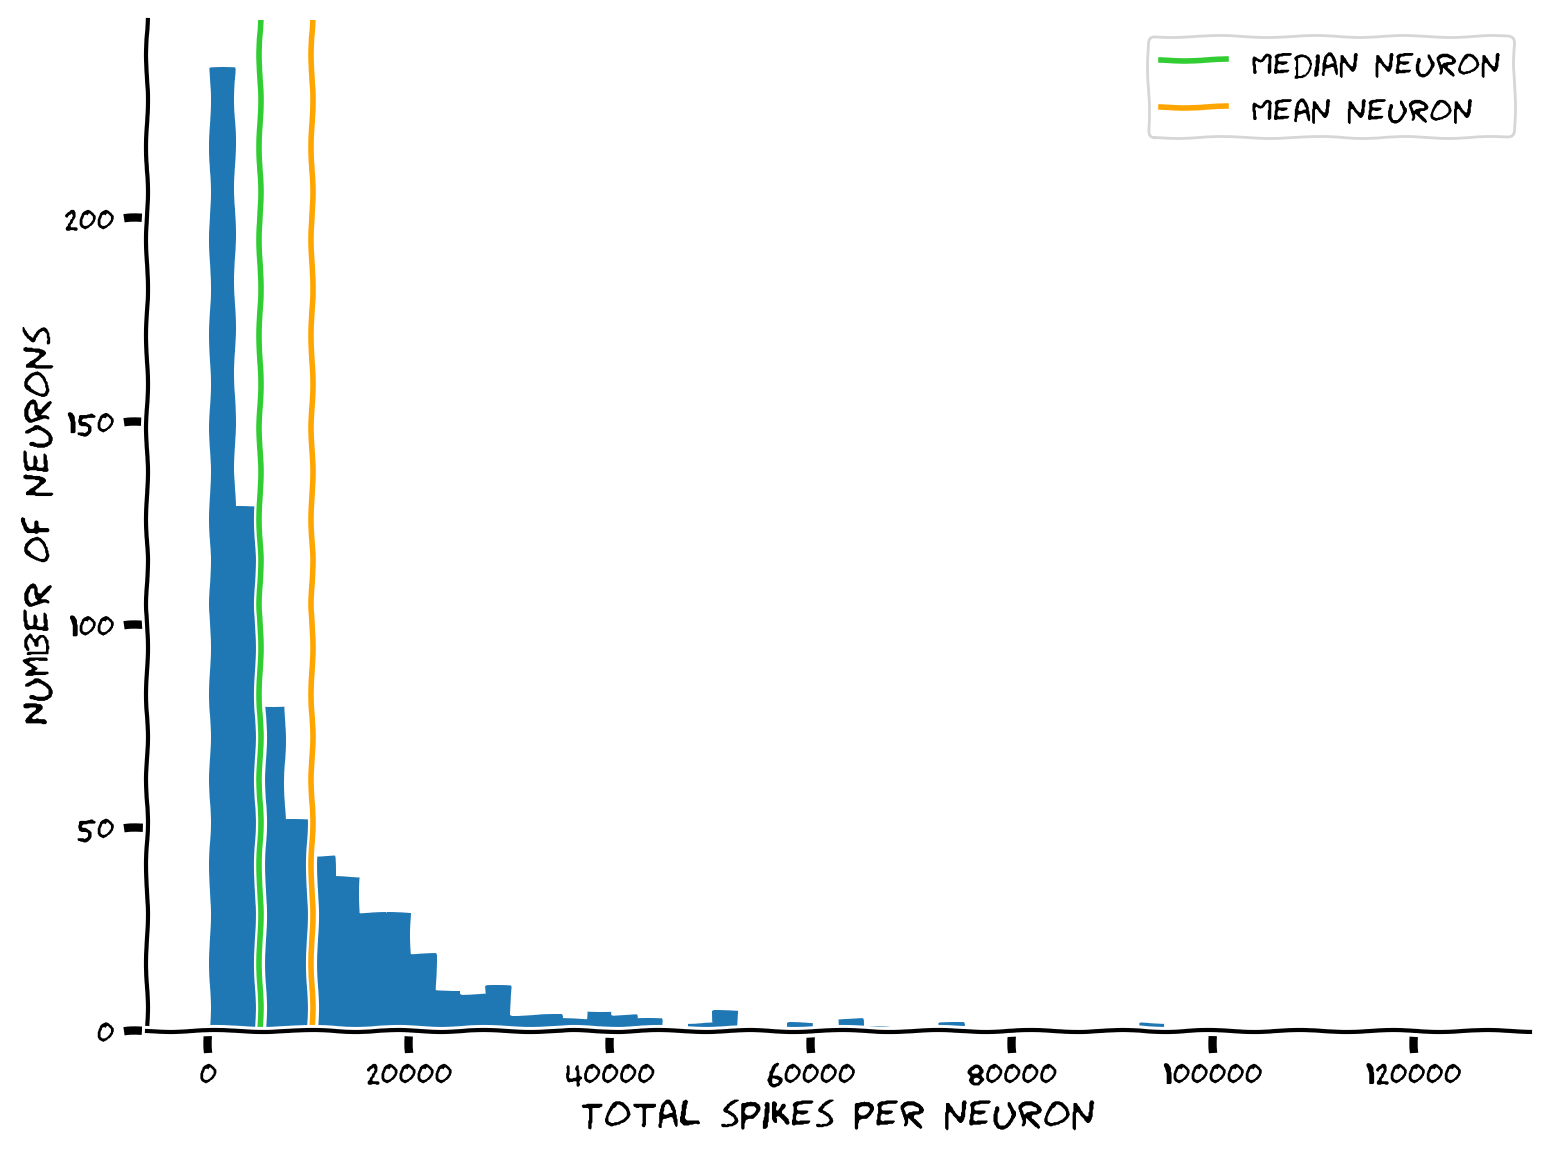

In [13]:
#@title coding exercise 1
#################################################################################
## TODO for students:
# Fill out function and remove
#raise NotImplementedError("Student exercise: complete histogram plotting with median")
#################################################################################

# Compute median spike count
median_spike_count = np.median(total_spikes_per_neuron)  # Hint: Try the function np.median

# Visualize median, mean, and histogram
with plt.xkcd():
 plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
 plt.axvline(median_spike_count, color="limegreen", label="Median neuron")
 plt.axvline(mean_spike_count, color="orange", label="Mean neuron")
 plt.xlabel("Total spikes per neuron")
 plt.ylabel("Number of neurons")
 plt.legend()

In [14]:
# @markdown Execute this cell for helper function `restrict_spike_times`
def restrict_spike_times(spike_times, interval):
  """Given a spike_time dataset, restrict to spikes within given interval.

  Args:
    spike_times (sequence of np.ndarray): List or array of arrays,
      each inner array has spike times for a single neuron.
    interval (tuple): Min, max time values; keep min <= t < max.

  Returns:
    np.ndarray: like `spike_times`, but only within `interval`
  """
  interval_spike_times = []
  for spikes in spike_times:
    interval_mask = (spikes >= interval[0]) & (spikes < interval[1])
    interval_spike_times.append(spikes[interval_mask])
  return np.array(interval_spike_times, object)

In [15]:
help(restrict_spike_times)

Help on function restrict_spike_times in module __main__:

restrict_spike_times(spike_times, interval)
    Given a spike_time dataset, restrict to spikes within given interval.
    
    Args:
      spike_times (sequence of np.ndarray): List or array of arrays,
        each inner array has spike times for a single neuron.
      interval (tuple): Min, max time values; keep min <= t < max.
    
    Returns:
      np.ndarray: like `spike_times`, but only within `interval`



In [16]:
t_interval = (5, 15)  # units are seconds after start of recording
interval_spike_times = restrict_spike_times(spike_times, t_interval)

In [17]:
original_counts = sum([len(spikes) for spikes in spike_times])
interval_counts = sum([len(spikes) for spikes in interval_spike_times])
frac_interval_spikes = interval_counts / original_counts
print(f"{frac_interval_spikes:.2%} of the total spikes are in the interval")

0.33% of the total spikes are in the interval


In [18]:
spike_times_flat = np.concatenate(spike_times)
experiment_duration = np.ptp(spike_times_flat)
interval_duration = t_interval[1] - t_interval[0]

frac_interval_time = interval_duration / experiment_duration
print(f"{frac_interval_time:.2%} of the total time is in the interval")

0.37% of the total time is in the interval


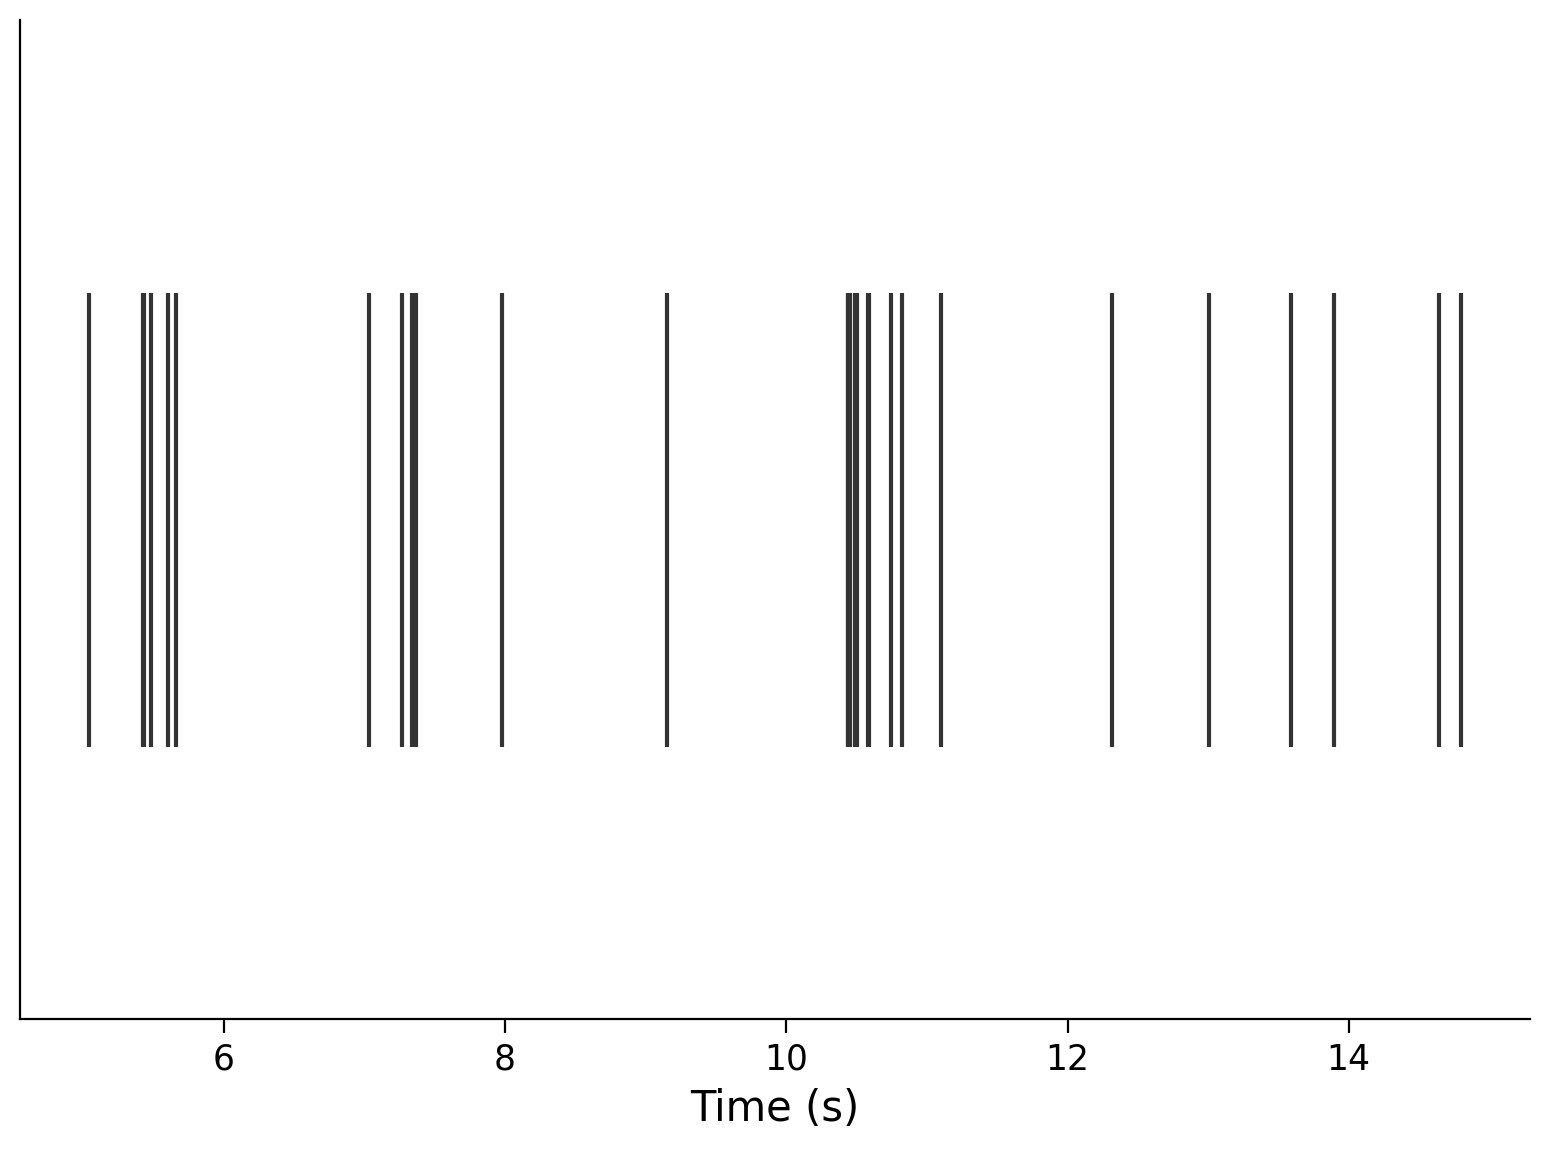

In [19]:
neuron_idx = 1
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

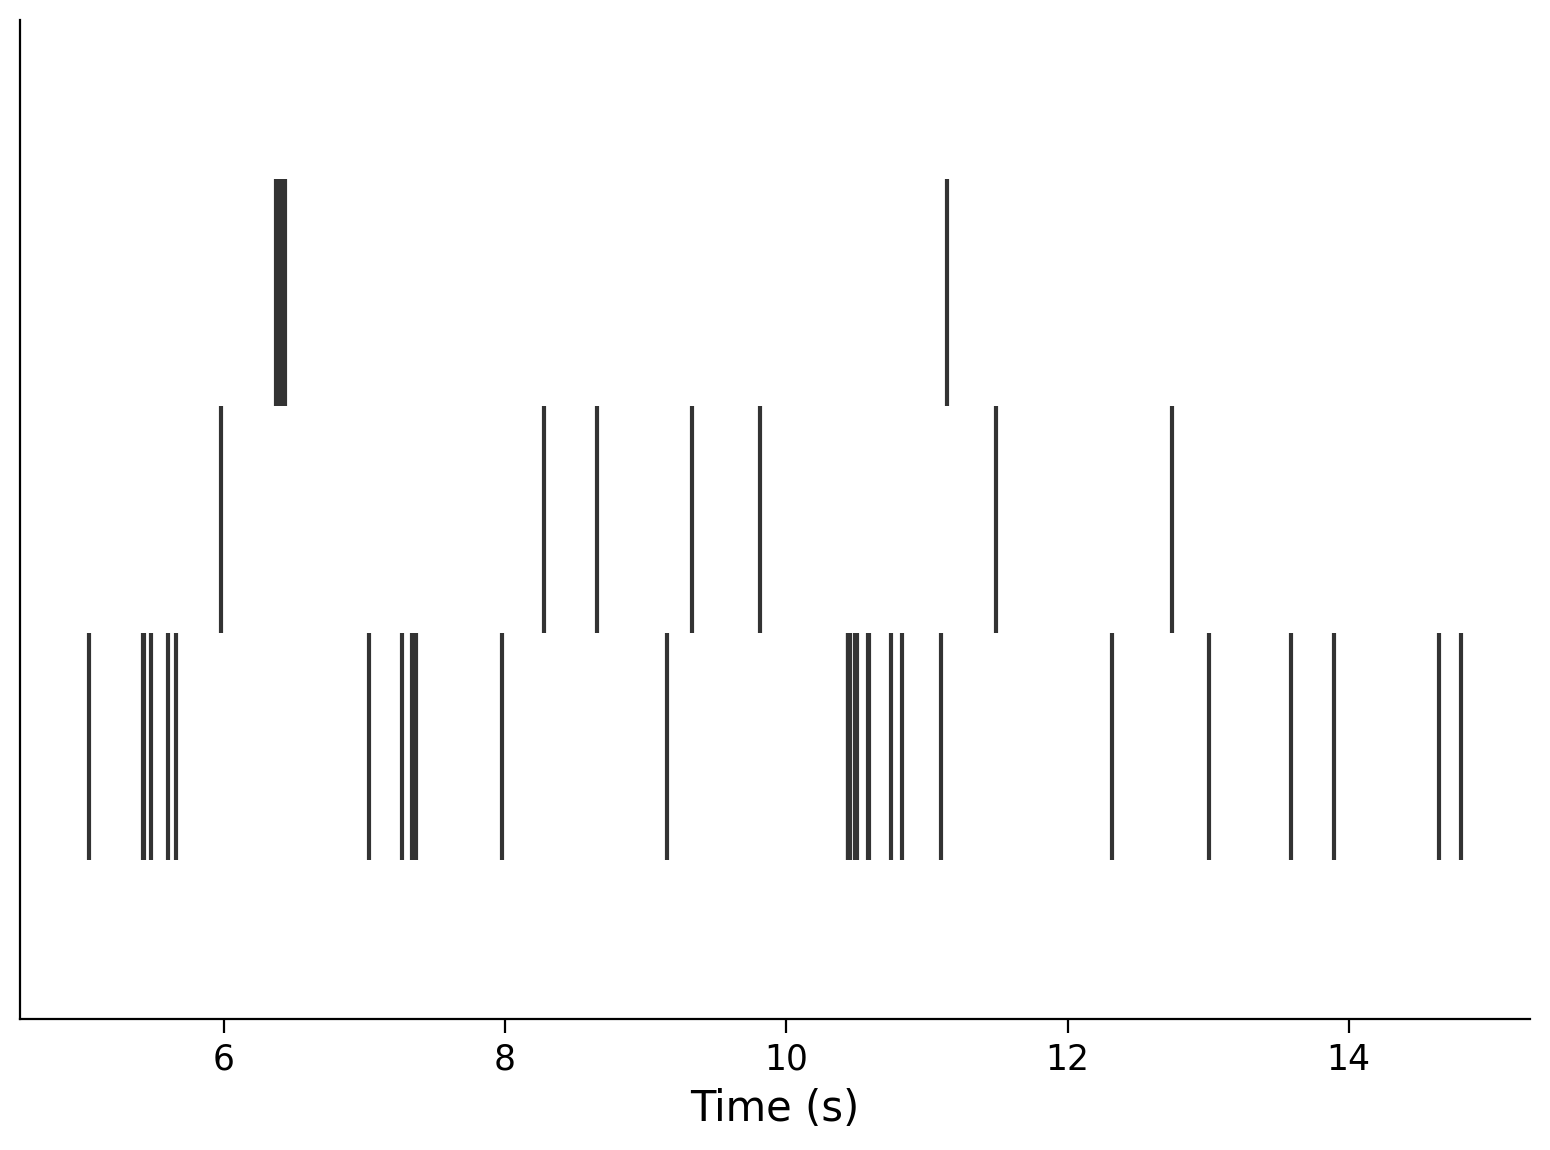

In [20]:
neuron_idx = [1, 11, 51]
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

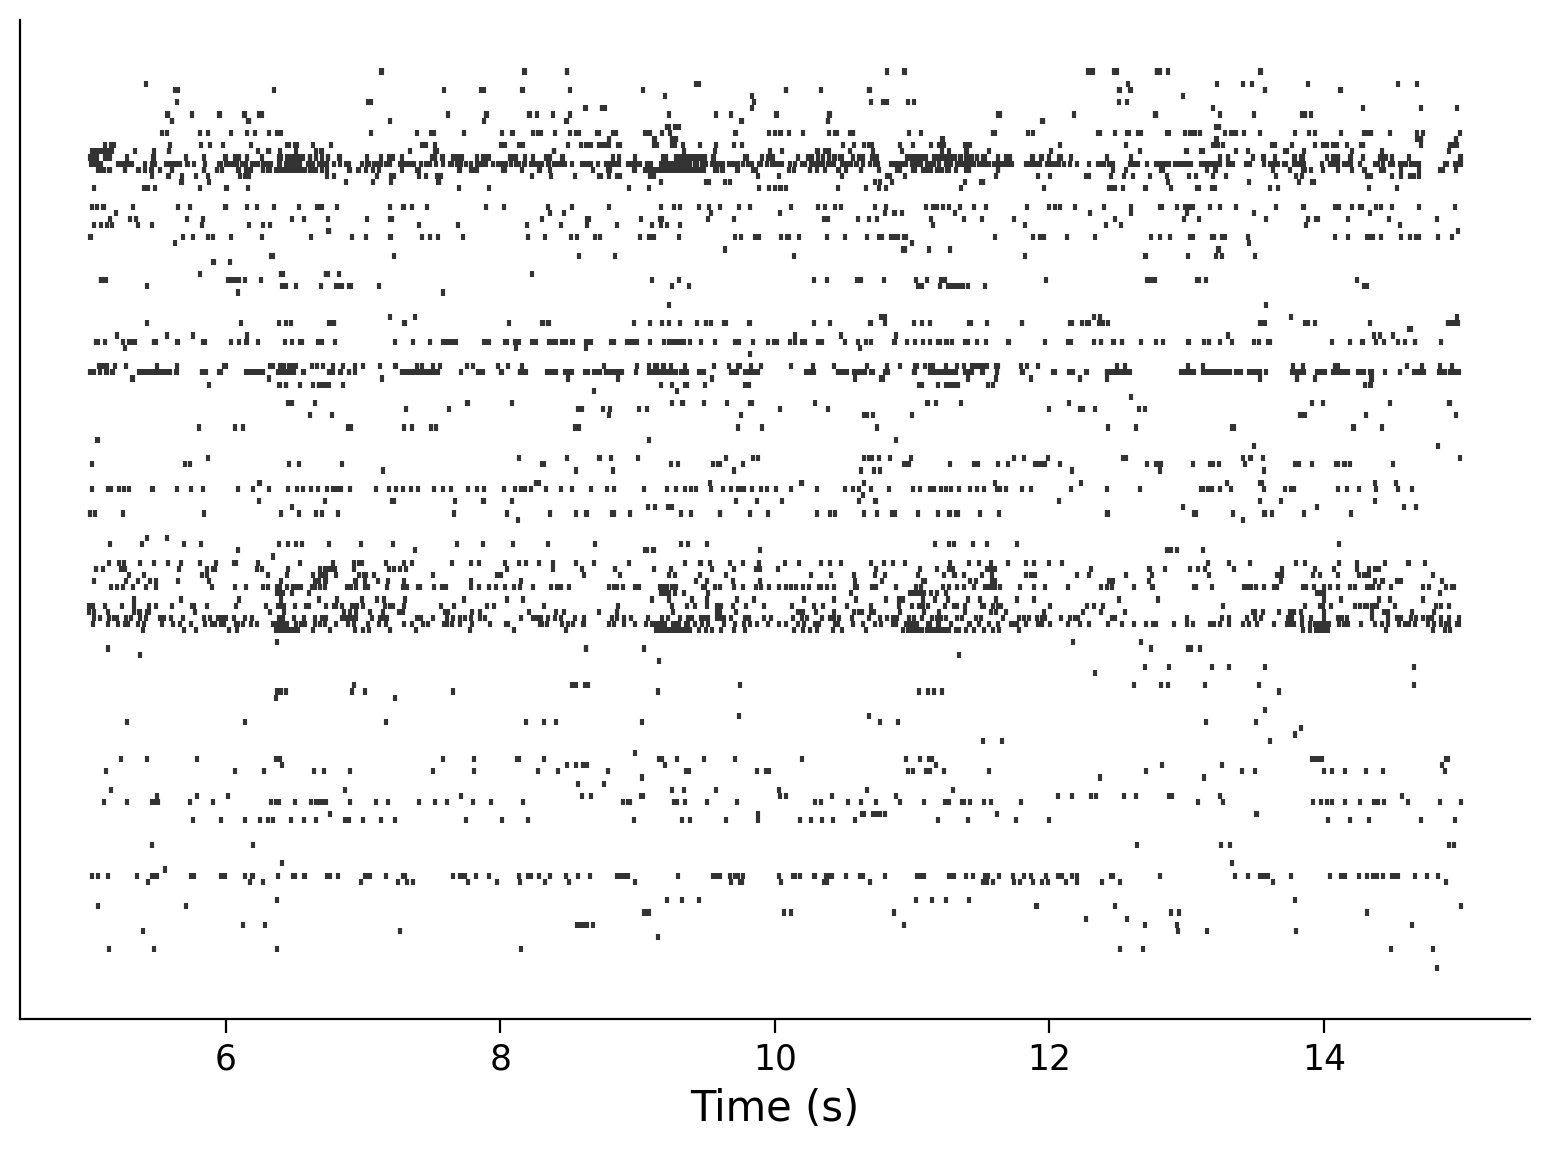

In [21]:
neuron_idx = np.arange(0, len(spike_times), 5)
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

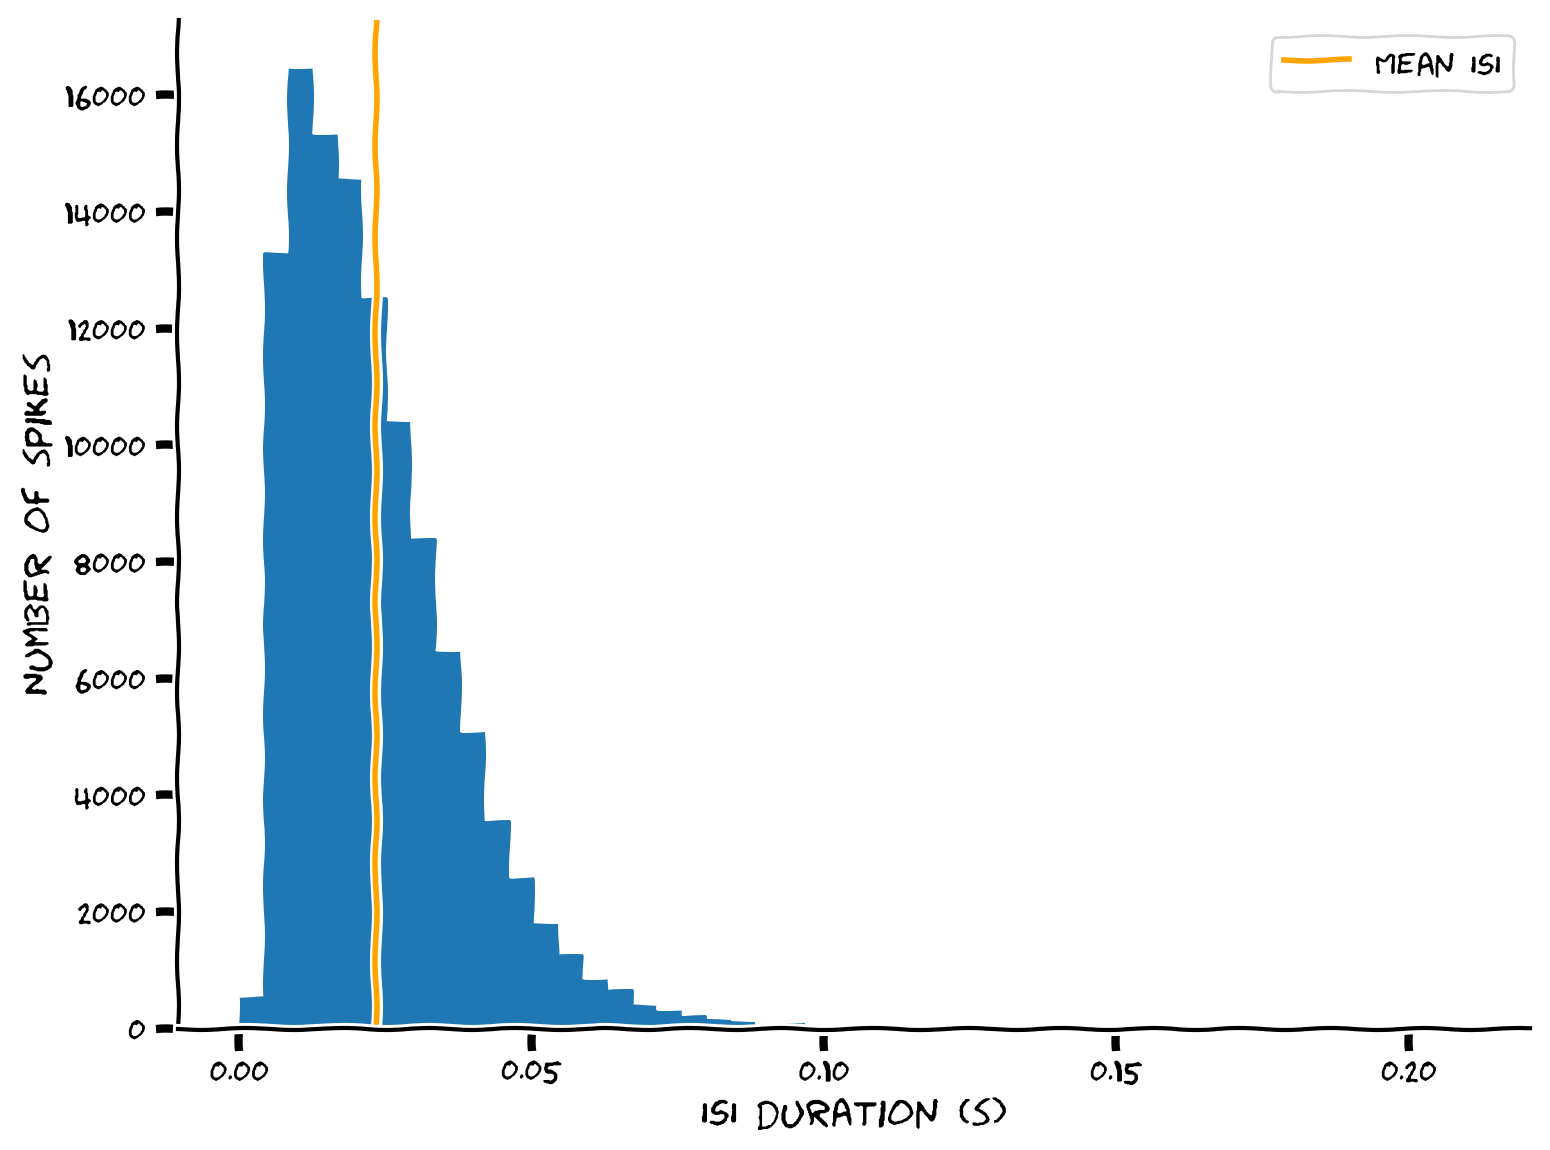

In [22]:
def compute_single_neuron_isis(spike_times, neuron_idx):
  """Compute a vector of ISIs for a single neuron given spike times.

  Args:
    spike_times (list of 1D arrays): Spike time dataset, with the first
      dimension corresponding to different neurons.
    neuron_idx (int): Index of the unit to compute ISIs for.

  Returns:
    isis (1D array): Duration of time between each spike from one neuron.
  """
  #############################################################################
  # Students: Fill in missing code (...) and comment or remove the next line
  #raise NotImplementedError("Exercise: compute single neuron ISIs")
  #############################################################################

  # Extract the spike times for the specified neuron
  single_neuron_spikes = spike_times[neuron_idx]

  # Compute the ISIs for this set of spikes
  # Hint: the function np.diff computes discrete differences along an array
  isis = np.diff(single_neuron_spikes)

  return isis

# Compute ISIs
single_neuron_isis = compute_single_neuron_isis(spike_times, neuron_idx=283)

# Visualize ISIs
with plt.xkcd():
 plot_isis(single_neuron_isis)

In [23]:
def exponential(xs, scale, rate, x0):
  """A simple parameterized exponential function, applied element-wise.

  Args:
    xs (np.ndarray or float): Input(s) to the function.
    scale (float): Linear scaling factor.
    rate (float): Exponential growth (positive) or decay (negative) rate.
    x0 (float): Horizontal offset.

  """
  ys = scale * np.exp(rate * (xs - x0))
  return ys

def inverse(xs, scale, x0):
  """A simple parameterized inverse function (`1/x`), applied element-wise.

  Args:
    xs (np.ndarray or float): Input(s) to the function.
    scale (float): Linear scaling factor.
    x0 (float): Horizontal offset.

  """
  ys = scale / (xs - x0)
  return ys

def linear(xs, slope, y0):
  """A simple linear function, applied element-wise.

  Args:
    xs (np.ndarray or float): Input(s) to the function.
    slope (float): Slope of the line.
    y0 (float): y-intercept of the line.

  """
  ys = slope * xs + y0
  return ys

interactive(children=(FloatSlider(value=1000.0, description='exp_scale', max=20000.0, step=250.0), FloatSlider…

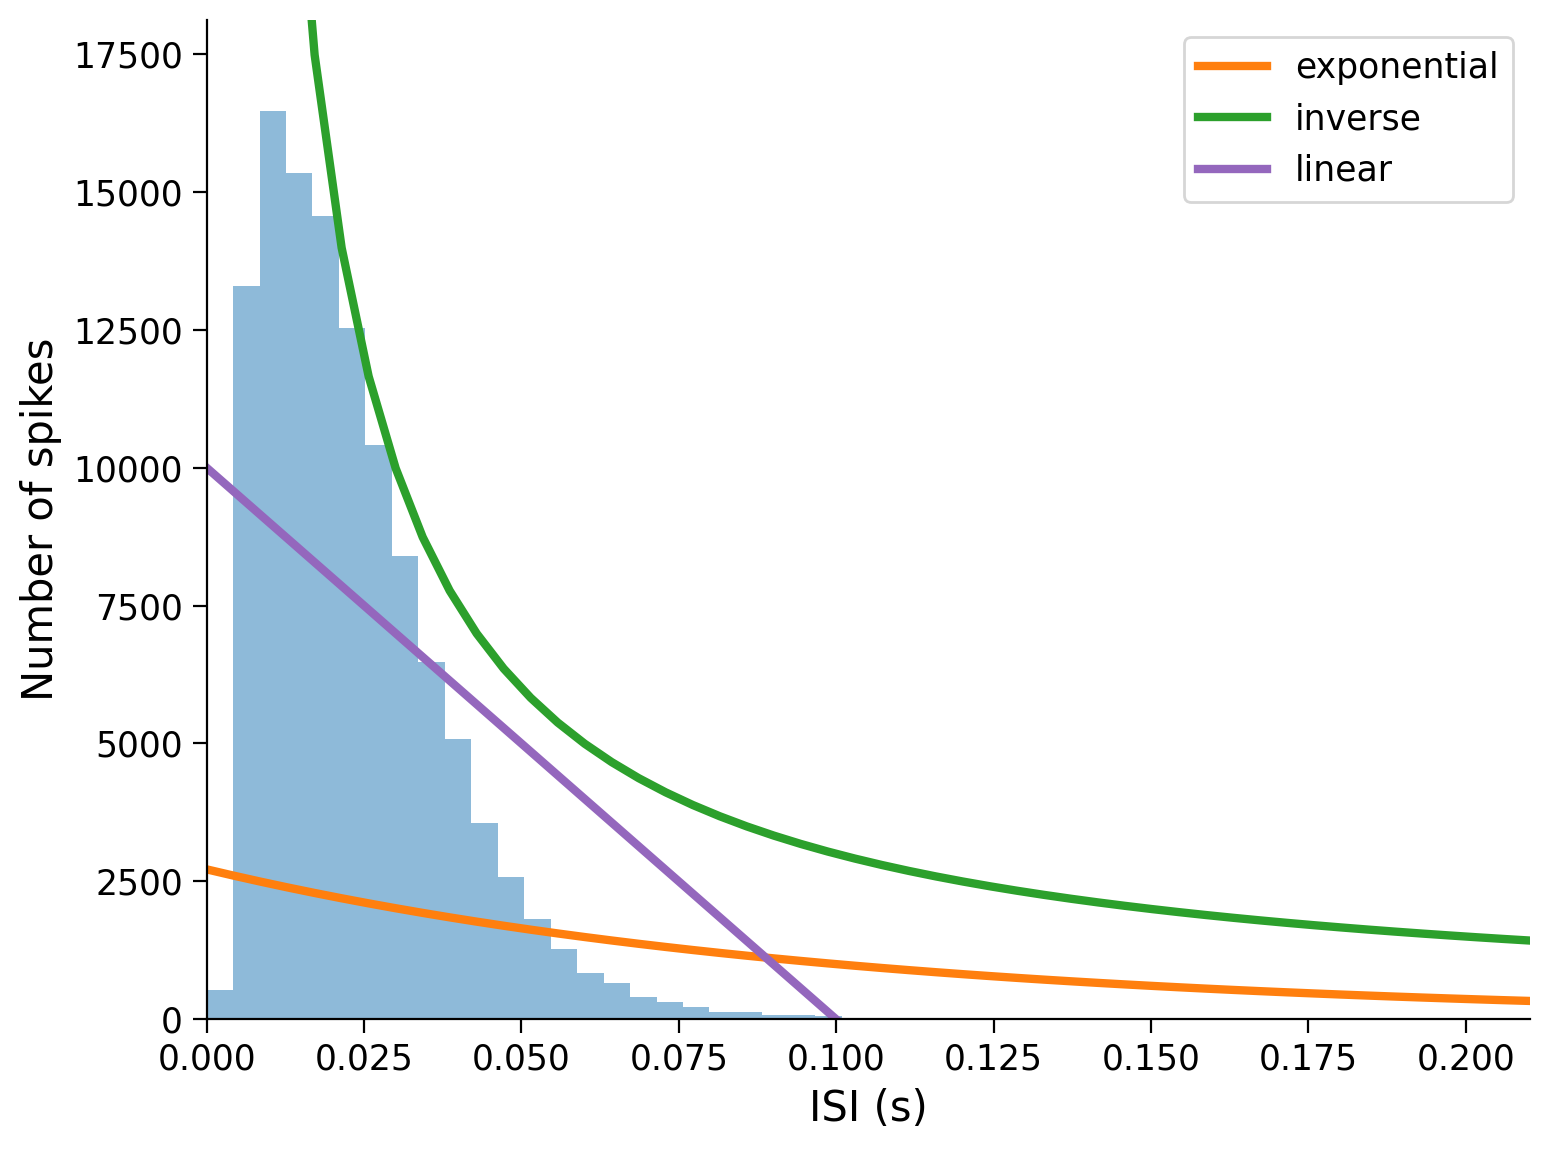

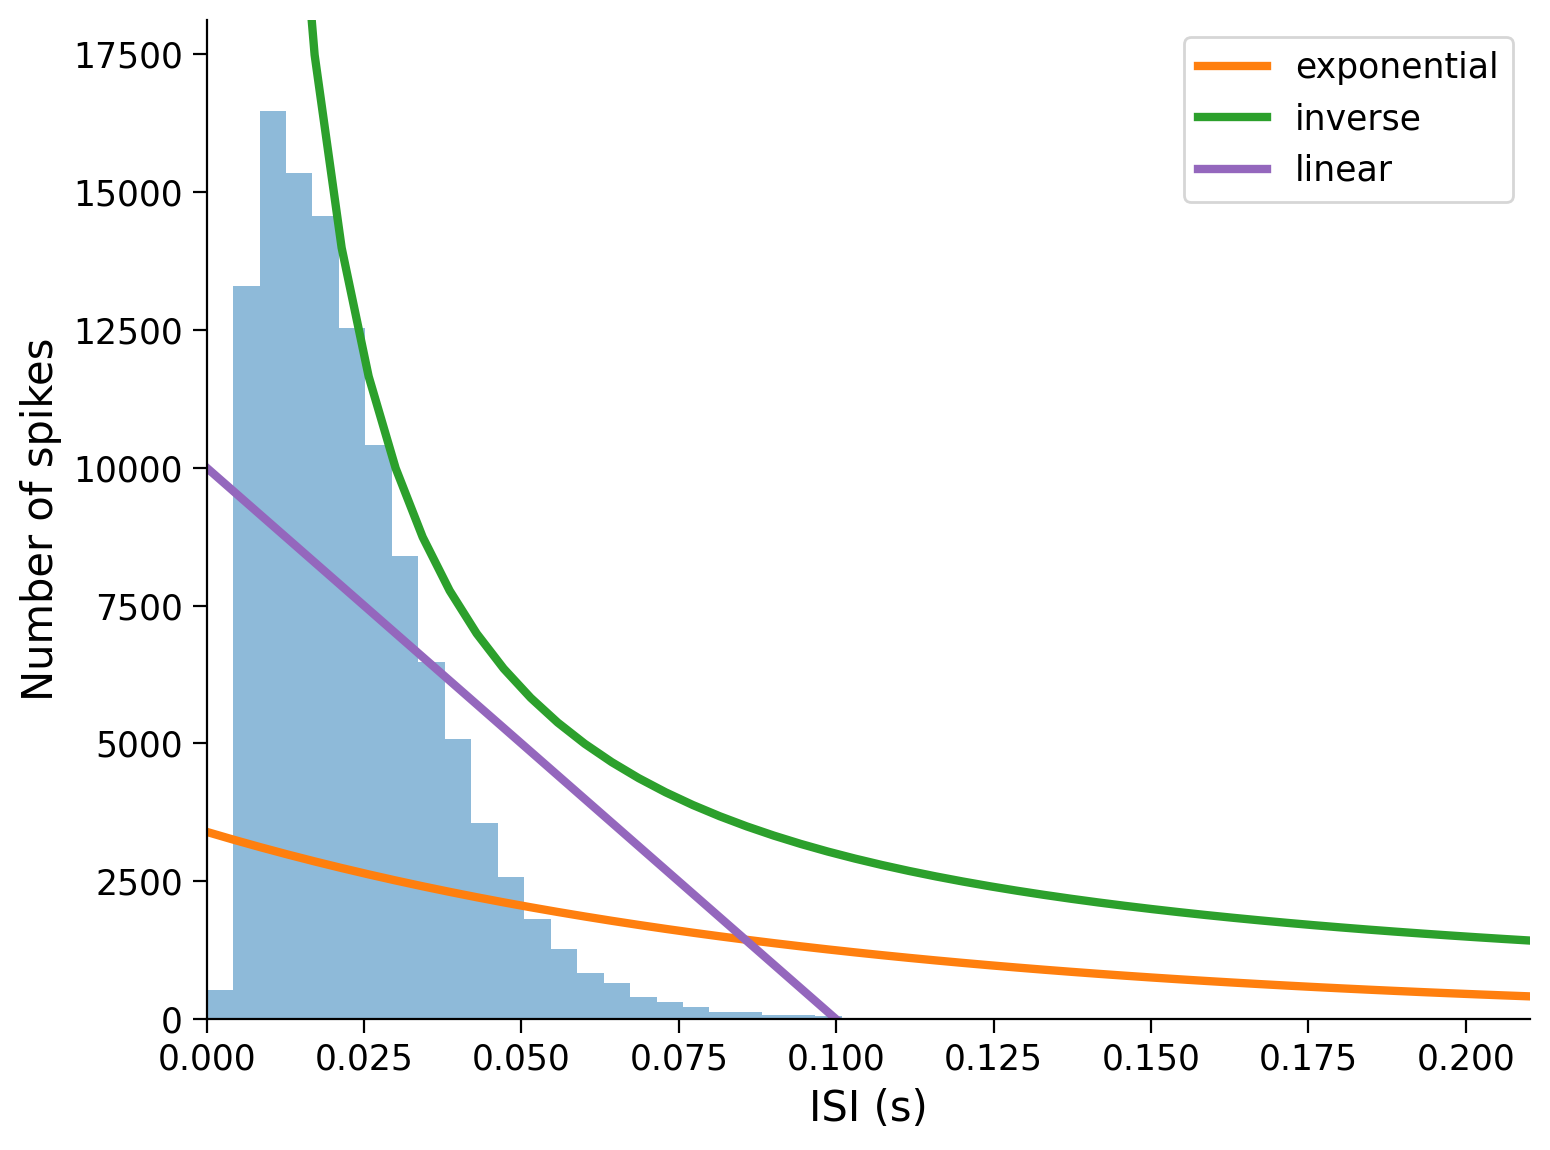

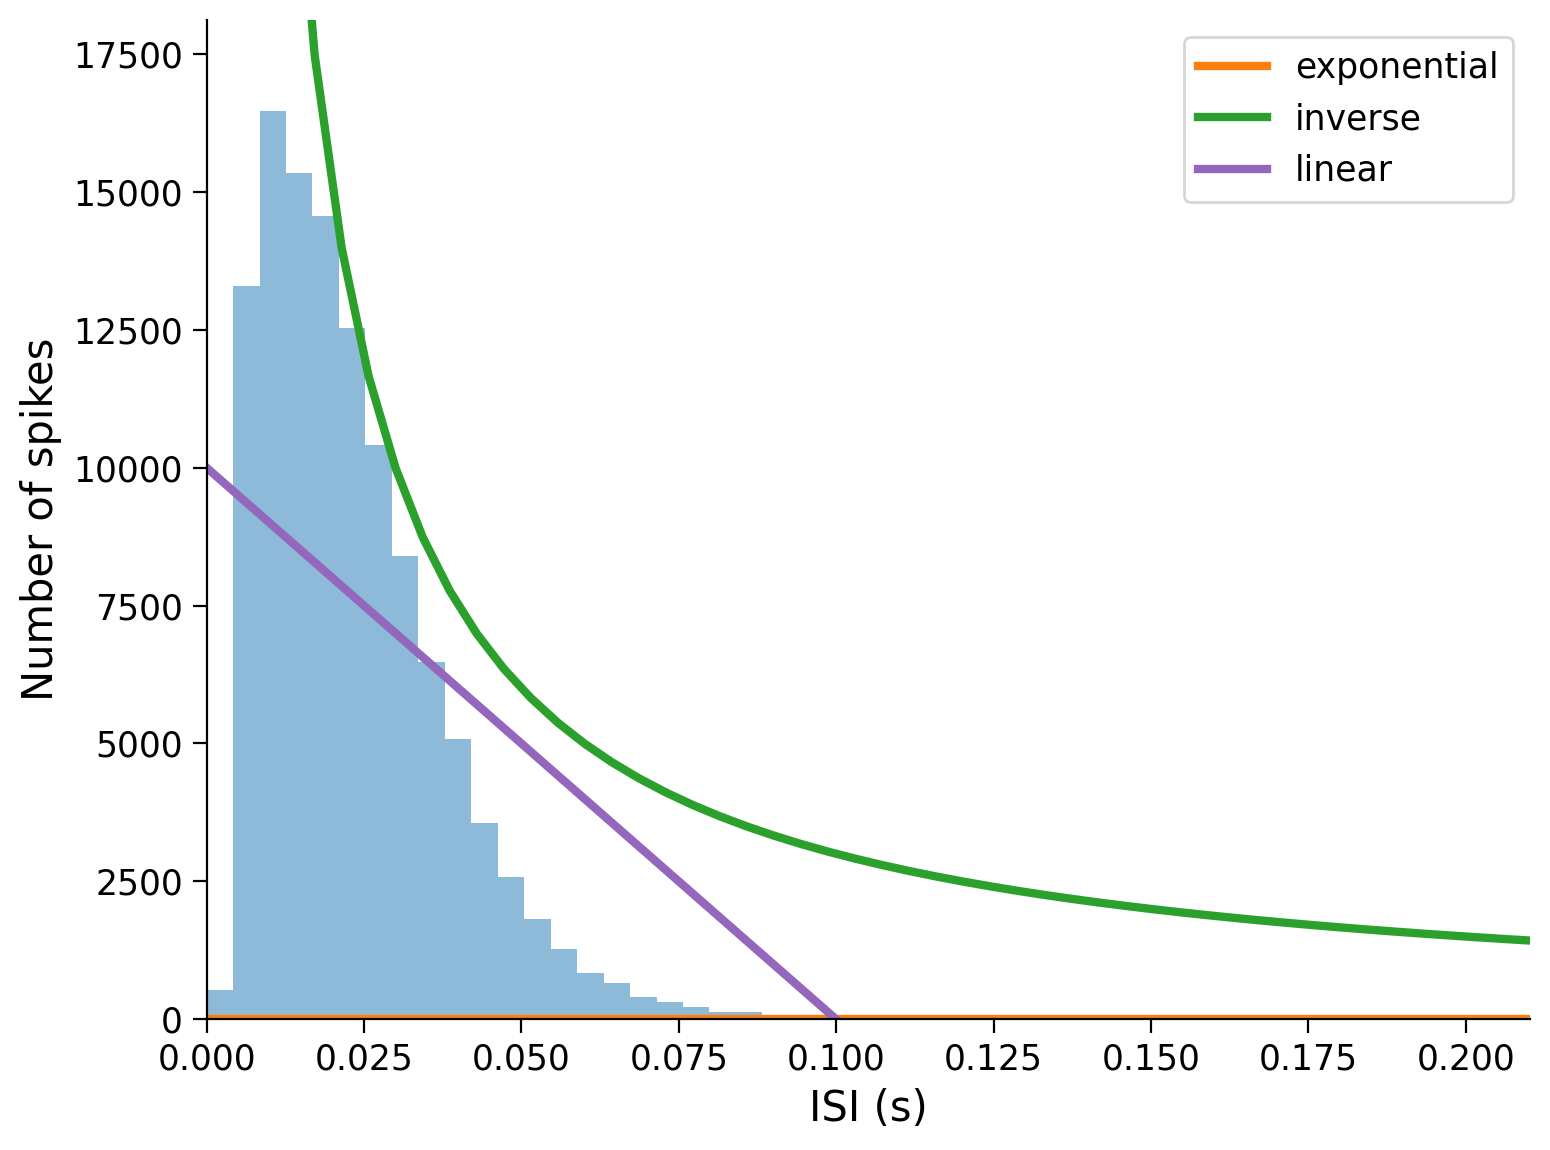

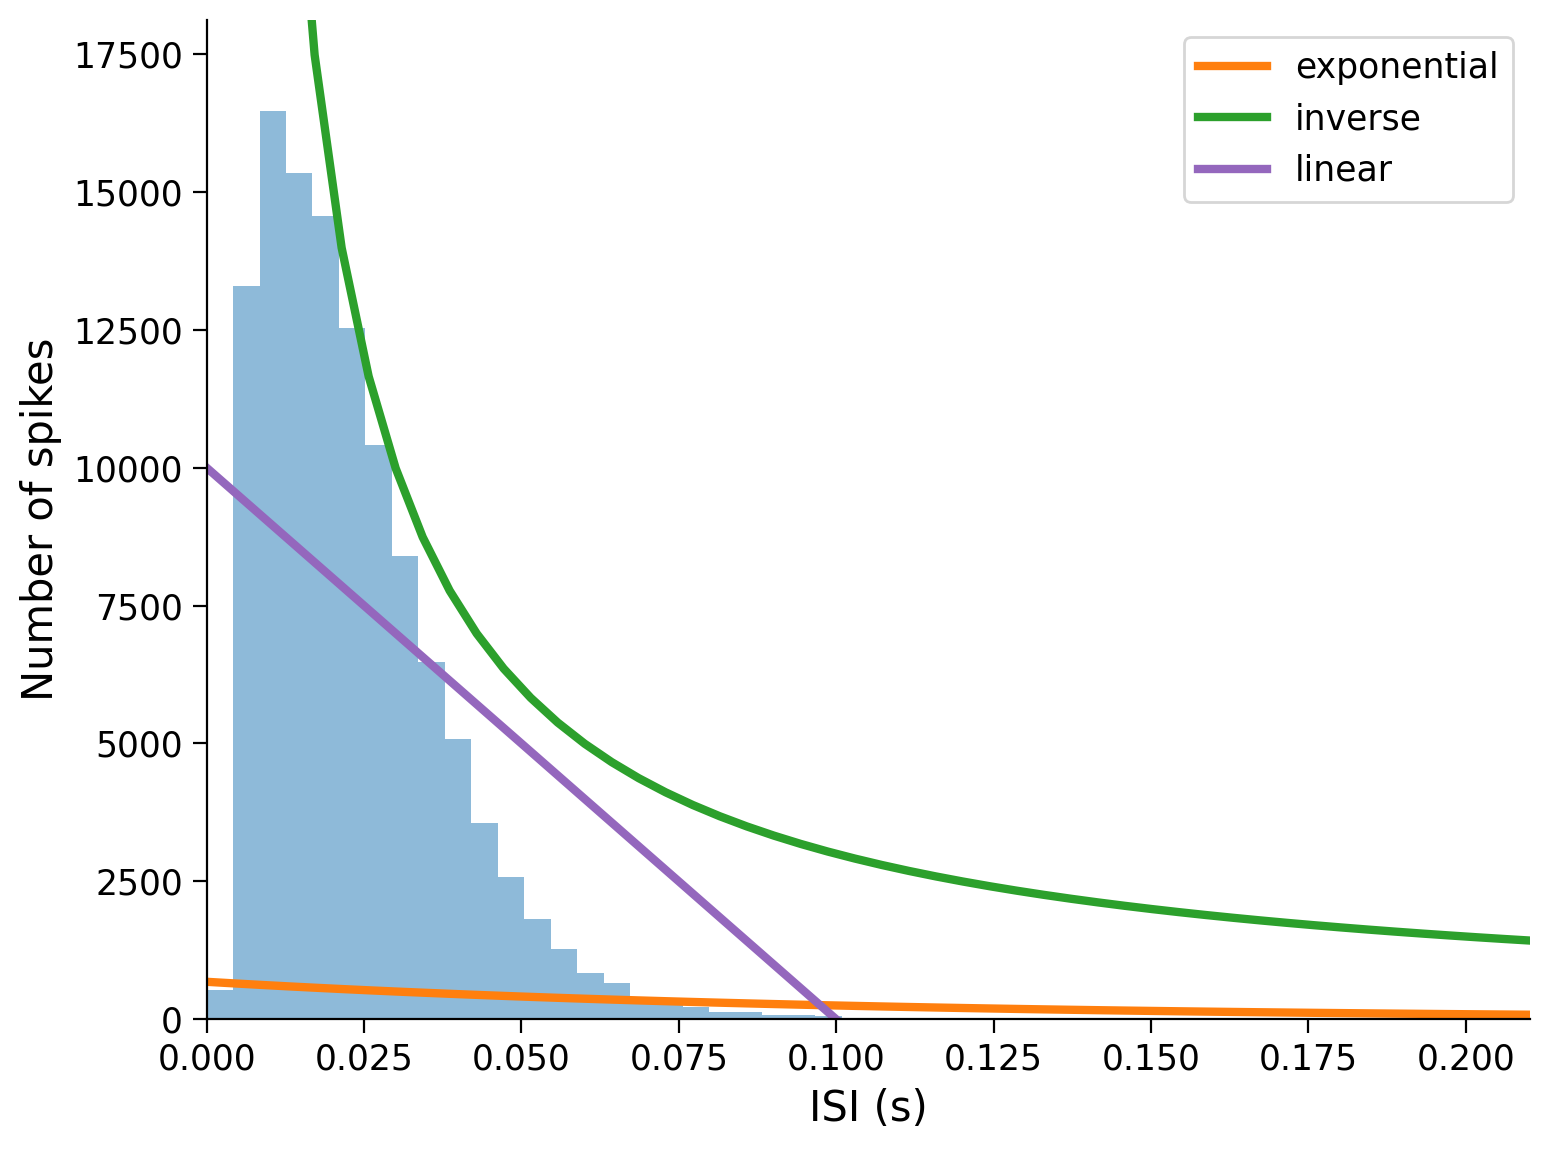

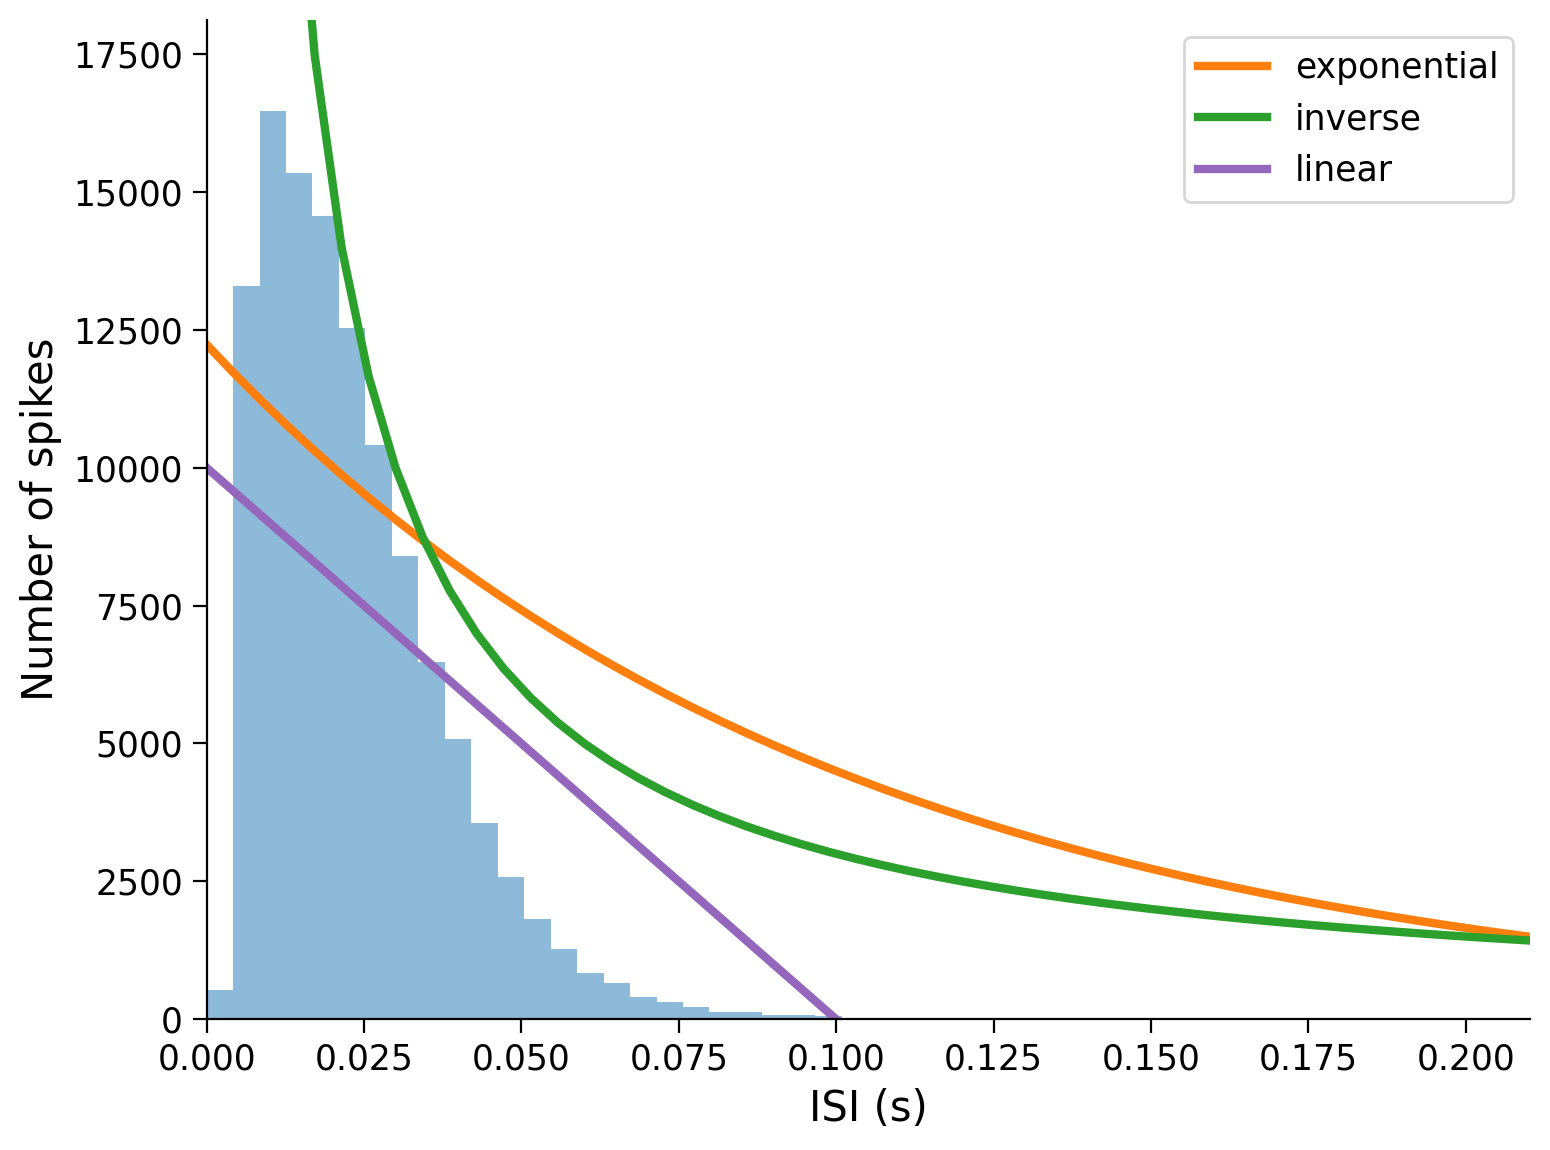

In [24]:
#@title

#@markdown Be sure to run this cell to enable the demo
# Don't worry about understanding this code! It's to setup an interactive plot.
single_neuron_idx = 283
single_neuron_spikes = spike_times[single_neuron_idx]
single_neuron_isis = np.diff(single_neuron_spikes)

counts, edges = np.histogram(
  single_neuron_isis,
  bins=50,
  range=(0, single_neuron_isis.max())
)

functions = dict(
  exponential=exponential,
  inverse=inverse,
  linear=linear,
)

colors = dict(
  exponential="C1",
  inverse="C2",
  linear="C4",
)

@widgets.interact(
  exp_scale=widgets.FloatSlider(1000, min=0, max=20000, step=250),
  exp_rate=widgets.FloatSlider(-10, min=-200, max=50, step=1),
  exp_x0=widgets.FloatSlider(0.1, min=-0.5, max=0.5, step=0.005),
  inv_scale=widgets.FloatSlider(1000, min=0, max=3e2, step=10),
  inv_x0=widgets.FloatSlider(0, min=-0.2, max=0.2, step=0.01),
  lin_slope=widgets.FloatSlider(-1e5, min=-6e5, max=1e5, step=10000),
  lin_y0=widgets.FloatSlider(10000, min=0, max=4e4, step=1000),
)
def fit_plot(
  exp_scale=1000, exp_rate=-10, exp_x0=0.1,
  inv_scale=1000, inv_x0=0,
  lin_slope=-1e5, lin_y0=2000,
):
  """Helper function for plotting function fits with interactive sliders."""
  func_params = dict(
    exponential=(exp_scale, exp_rate, exp_x0),
    inverse=(inv_scale, inv_x0),
    linear=(lin_slope, lin_y0),
  )
  f, ax = plt.subplots()
  ax.fill_between(edges[:-1], counts, step="post", alpha=.5)
  xs = np.linspace(1e-10, edges.max())
  for name, function in functions.items():
    ys = function(xs, *func_params[name])
    ax.plot(xs, ys, lw=3, color=colors[name], label=name);
  ax.set(
      xlim=(edges.min(), edges.max()),
      ylim=(0, counts.max() * 1.1),
      xlabel="ISI (s)",
      ylabel="Number of spikes",
  )
  ax.legend()

In [1]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
link_id = "6dxwe"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/6dxwe/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
#@title Figure Settings
import ipywidgets as widgets #interactive display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [4]:
# @title Plotting Functions

def histogram(counts, bins, vlines=(), ax=None, ax_args=None, **kwargs):
  """Plot a step histogram given counts over bins."""
  if ax is None:
    _, ax = plt.subplots()

  # duplicate the first element of `counts` to match bin edges
  counts = np.insert(counts, 0, counts[0])

  ax.fill_between(bins, counts, step="pre", alpha=0.4, **kwargs)  # area shading
  ax.plot(bins, counts, drawstyle="steps", **kwargs)  # lines

  for x in vlines:
    ax.axvline(x, color='r', linestyle='dotted')  # vertical line

  if ax_args is None:
    ax_args = {}

  # heuristically set max y to leave a bit of room
  ymin, ymax = ax_args.get('ylim', [None, None])
  if ymax is None:
    ymax = np.max(counts)
    if ax_args.get('yscale', 'linear') == 'log':
      ymax *= 1.5
    else:
      ymax *= 1.1
      if ymin is None:
        ymin = 0

  if ymax == ymin:
    ymax = None

  ax_args['ylim'] = [ymin, ymax]

  ax.set(**ax_args)
  ax.autoscale(enable=False, axis='x', tight=True)

def plot_neuron_stats(v, spike_times):
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

  # membrane voltage trace
  ax1.plot(v[0:100])
  ax1.set(xlabel='Time', ylabel='Voltage')
  # plot spike events
  for x in spike_times:
    if x >= 100:
      break
    ax1.axvline(x, color='red')

  # ISI distribution
  if len(spike_times)>1:
    isi = np.diff(spike_times)
    n_bins = np.arange(isi.min(), isi.max() + 2) - .5
    counts, bins = np.histogram(isi, n_bins)
    vlines = []
    if len(isi) > 0:
      vlines = [np.mean(isi)]
    xmax = max(20, int(bins[-1])+5)
    histogram(counts, bins, vlines=vlines, ax=ax2, ax_args={
      'xlabel': 'Inter-spike interval',
      'ylabel': 'Number of intervals',
      'xlim': [0, xmax]
    })
  else:
    ax2.set(xlabel='Inter-spike interval',
           ylabel='Number of intervals')
  plt.show()

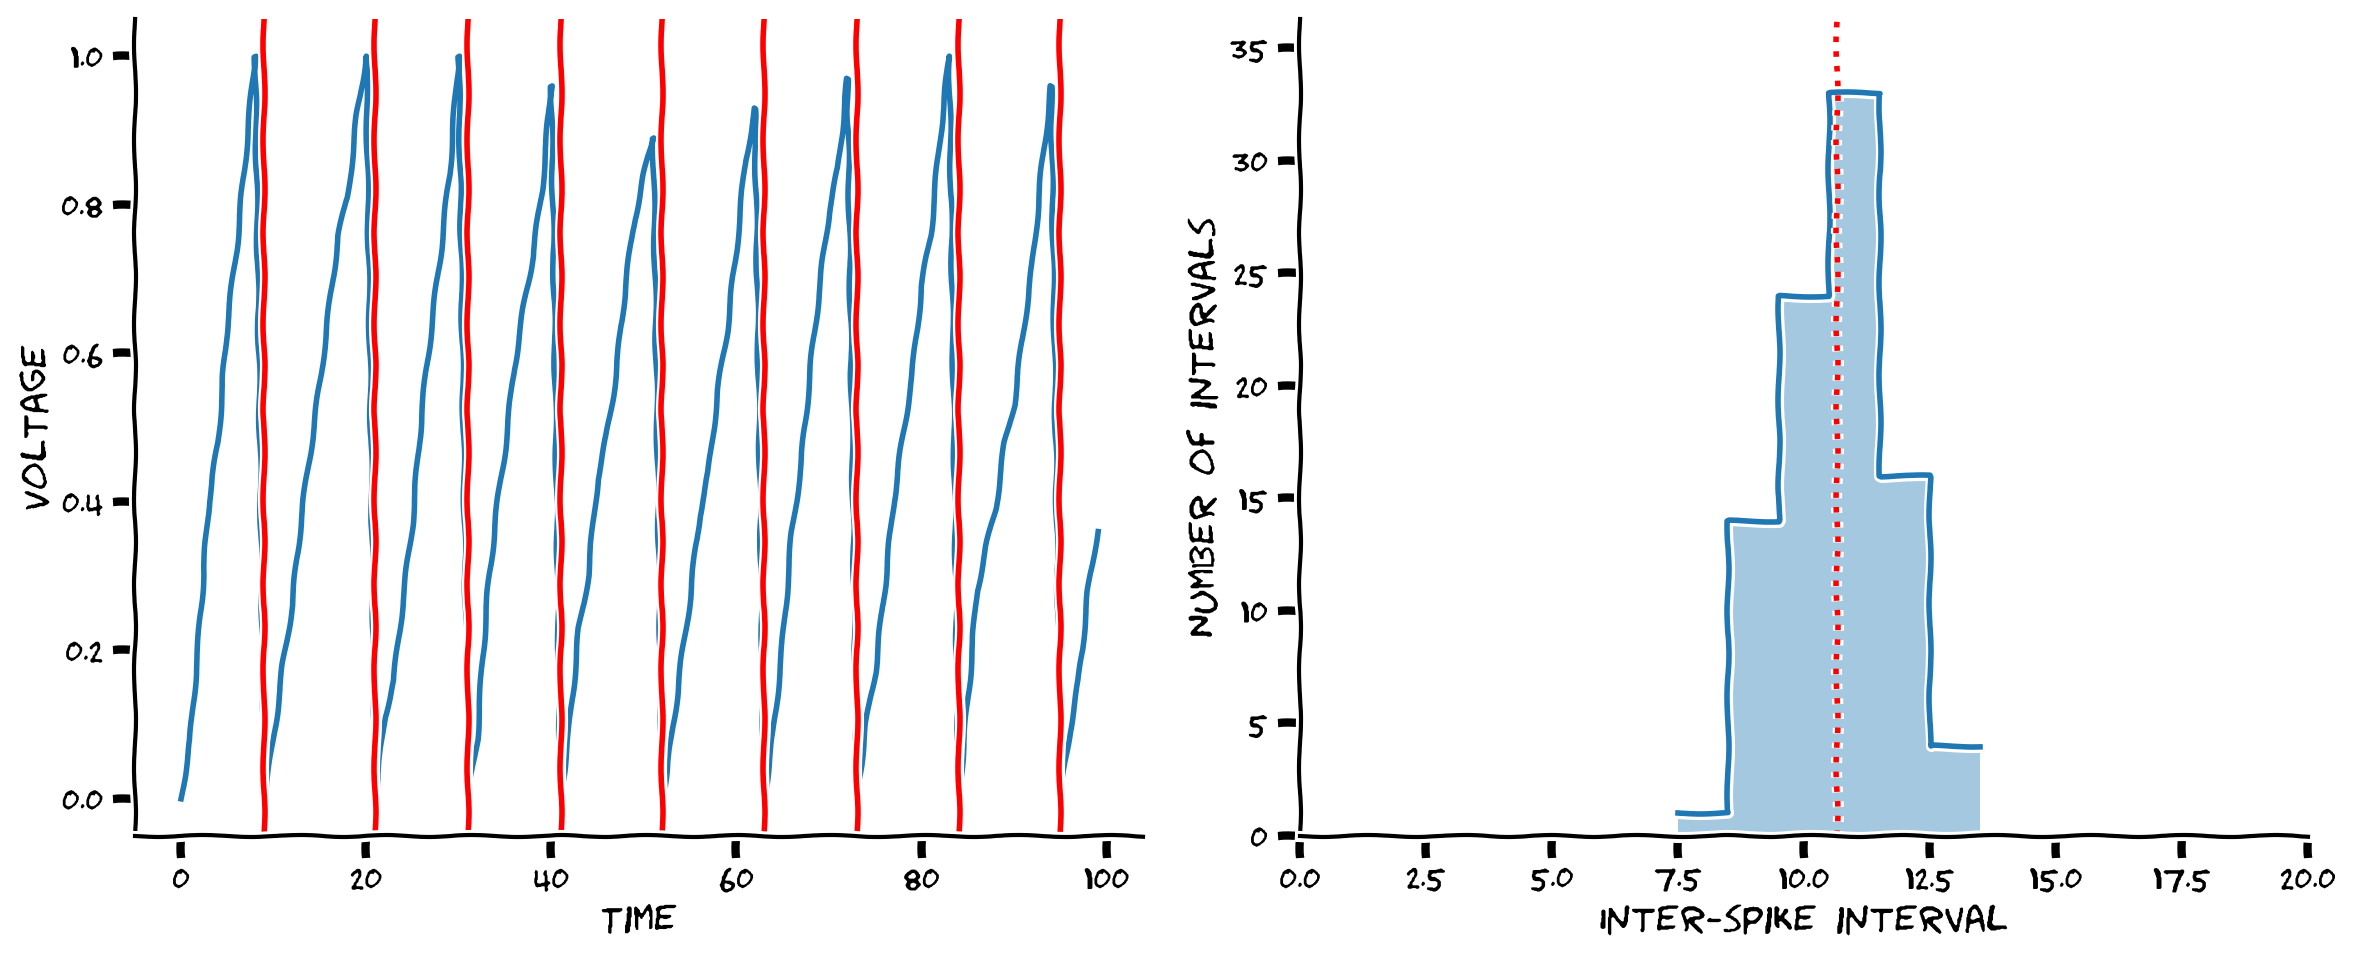

In [5]:
def lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  """ Simulate a linear integrate-and-fire neuron.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    rate (int): The mean rate of incoming spikes

  """
  # Precompute Poisson samples for speed
  exc = stats.poisson(rate).rvs(n_steps)

  # Initialize voltage and spike storage
  v = np.zeros(n_steps)
  spike_times = []

  ################################################################################
  # Students: compute dv, then comment out or remove the next line
  #raise NotImplementedError("Exercise: compute the change in membrane potential")
  ################################################################################

  # Loop over steps
  for i in range(1, n_steps):

    # Update v
    dv = alpha * exc[i]
    v[i] = v[i-1] + dv

    # If spike happens, reset voltage and record
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

# Set random seed (for reproducibility)
np.random.seed(12)

# Model LIF neuron
v, spike_times = lif_neuron()

# Visualize
with plt.xkcd():
 plot_neuron_stats(v, spike_times)

In [6]:
# @markdown You don't need to worry about how the code works – but you do need to **run the cell** to enable the sliders.

def _lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  exc = stats.poisson(rate).rvs(n_steps)
  v = np.zeros(n_steps)
  spike_times = []
  for i in range(1, n_steps):
    dv = alpha * exc[i]
    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0
  return v, spike_times

@widgets.interact(
  alpha=widgets.FloatLogSlider(0.01, min=-2, max=-1),
  rate=widgets.IntSlider(10, min=5, max=20)
)
def plot_lif_neuron(alpha=0.01, rate=10):
  v, spike_times = _lif_neuron(2000, alpha, rate)

  plot_neuron_stats(v, spike_times)

interactive(children=(FloatLogSlider(value=0.01, description='alpha', max=-1.0, min=-2.0), IntSlider(value=10,…

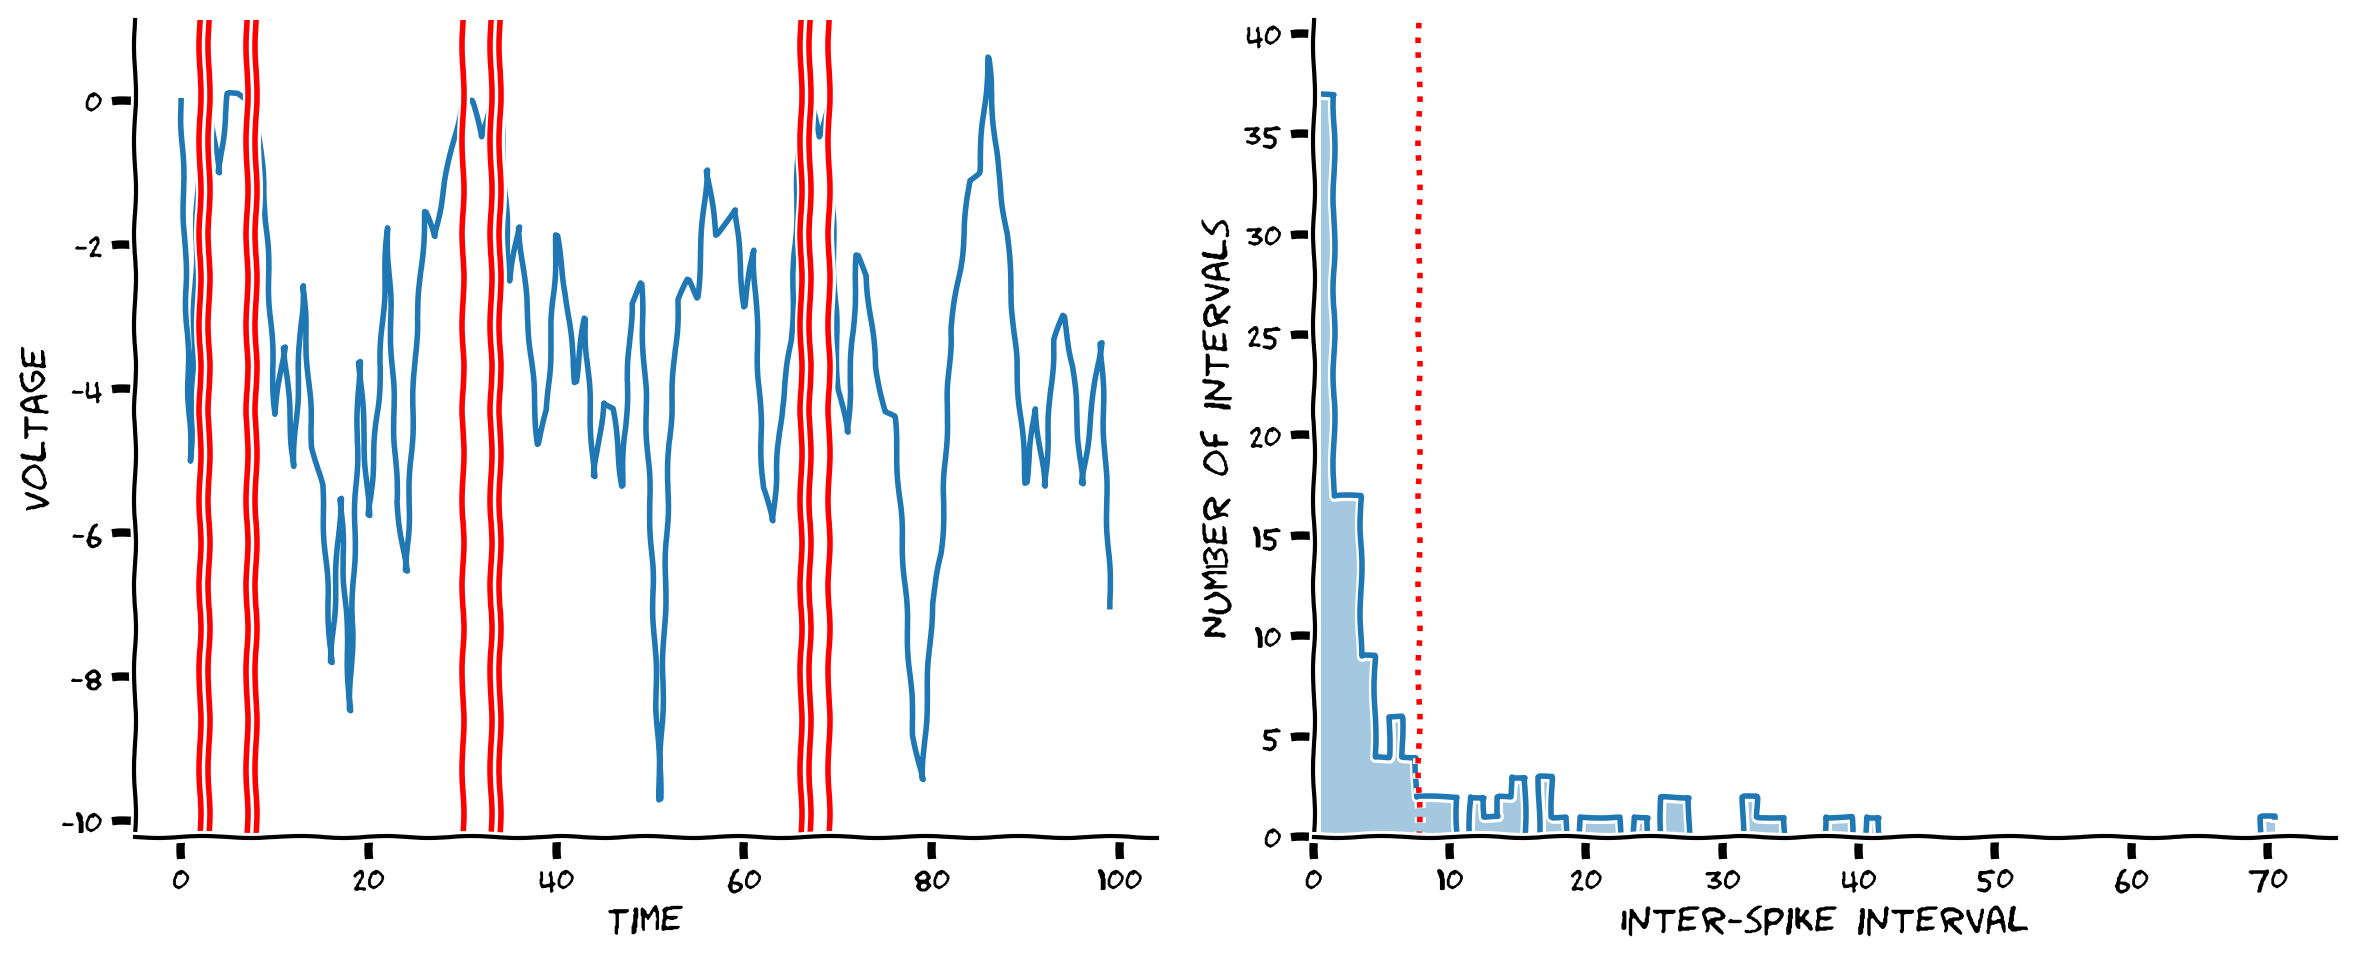

In [7]:
def lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  """ Simulate a simplified leaky integrate-and-fire neuron with both excitatory
  and inhibitory inputs.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    beta (float): The membrane potential leakage factor
    exc_rate (int): The mean rate of the incoming excitatory spikes
    inh_rate (int): The mean rate of the incoming inhibitory spikes
  """

  # precompute Poisson samples for speed
  exc = stats.poisson(exc_rate).rvs(n_steps)
  inh = stats.poisson(inh_rate).rvs(n_steps)

  v = np.zeros(n_steps)
  spike_times = []

  ###############################################################################
  # Students: compute dv, then comment out or remove the next line
  #raise NotImplementedError("Exercise: compute the change in membrane potential")
  ################################################################################

  for i in range(1, n_steps):

    dv = -beta * v[i-1] + alpha * (exc[i] - inh[i])

    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

# Set random seed (for reproducibility)
np.random.seed(12)

# Model LIF neuron
v, spike_times = lif_neuron_inh()

# Visualize
with plt.xkcd():
 plot_neuron_stats(v, spike_times)

In [8]:
#@title
#@markdown **Run the cell** to enable the sliders.
def _lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  """ Simulate a simplified leaky integrate-and-fire neuron with both excitatory
  and inhibitory inputs.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    beta (float): The membrane potential leakage factor
    exc_rate (int): The mean rate of the incoming excitatory spikes
    inh_rate (int): The mean rate of the incoming inhibitory spikes
  """
  # precompute Poisson samples for speed
  exc = stats.poisson(exc_rate).rvs(n_steps)
  inh = stats.poisson(inh_rate).rvs(n_steps)

  v = np.zeros(n_steps)
  spike_times = []
  for i in range(1, n_steps):
    dv = -beta * v[i-1] + alpha * (exc[i] - inh[i])
    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

@widgets.interact(alpha=widgets.FloatLogSlider(0.5, min=-1, max=1),
                  beta=widgets.FloatLogSlider(0.1, min=-1, max=0),
                  exc_rate=widgets.IntSlider(12, min=10, max=20),
                  inh_rate=widgets.IntSlider(12, min=10, max=20))
def plot_lif_neuron(alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  v, spike_times = _lif_neuron_inh(2000, alpha, beta, exc_rate, inh_rate)
  plot_neuron_stats(v, spike_times)

interactive(children=(FloatLogSlider(value=0.5, description='alpha', max=1.0, min=-1.0), FloatLogSlider(value=…

In [9]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
link_id = "6dxwe"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/6dxwe/


In [10]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [11]:
#@title Figure Settings
import ipywidgets as widgets #interactive display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [12]:
#@title Plotting Functions

def plot_pmf(pmf,isi_range):
  """Plot the probability mass function."""
  ymax = max(0.2, 1.05 * np.max(pmf))
  pmf_ = np.insert(pmf, 0, pmf[0])
  plt.plot(bins, pmf_, drawstyle="steps")
  plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
  plt.title(f"Neuron {neuron_idx}")
  plt.xlabel("Inter-spike interval (s)")
  plt.ylabel("Probability mass")
  plt.xlim(isi_range);
  plt.ylim([0, ymax])

In [13]:
#@title Download Data
import io
import requests
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
  print('Could not download data')
else:
  steinmetz_spikes = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']

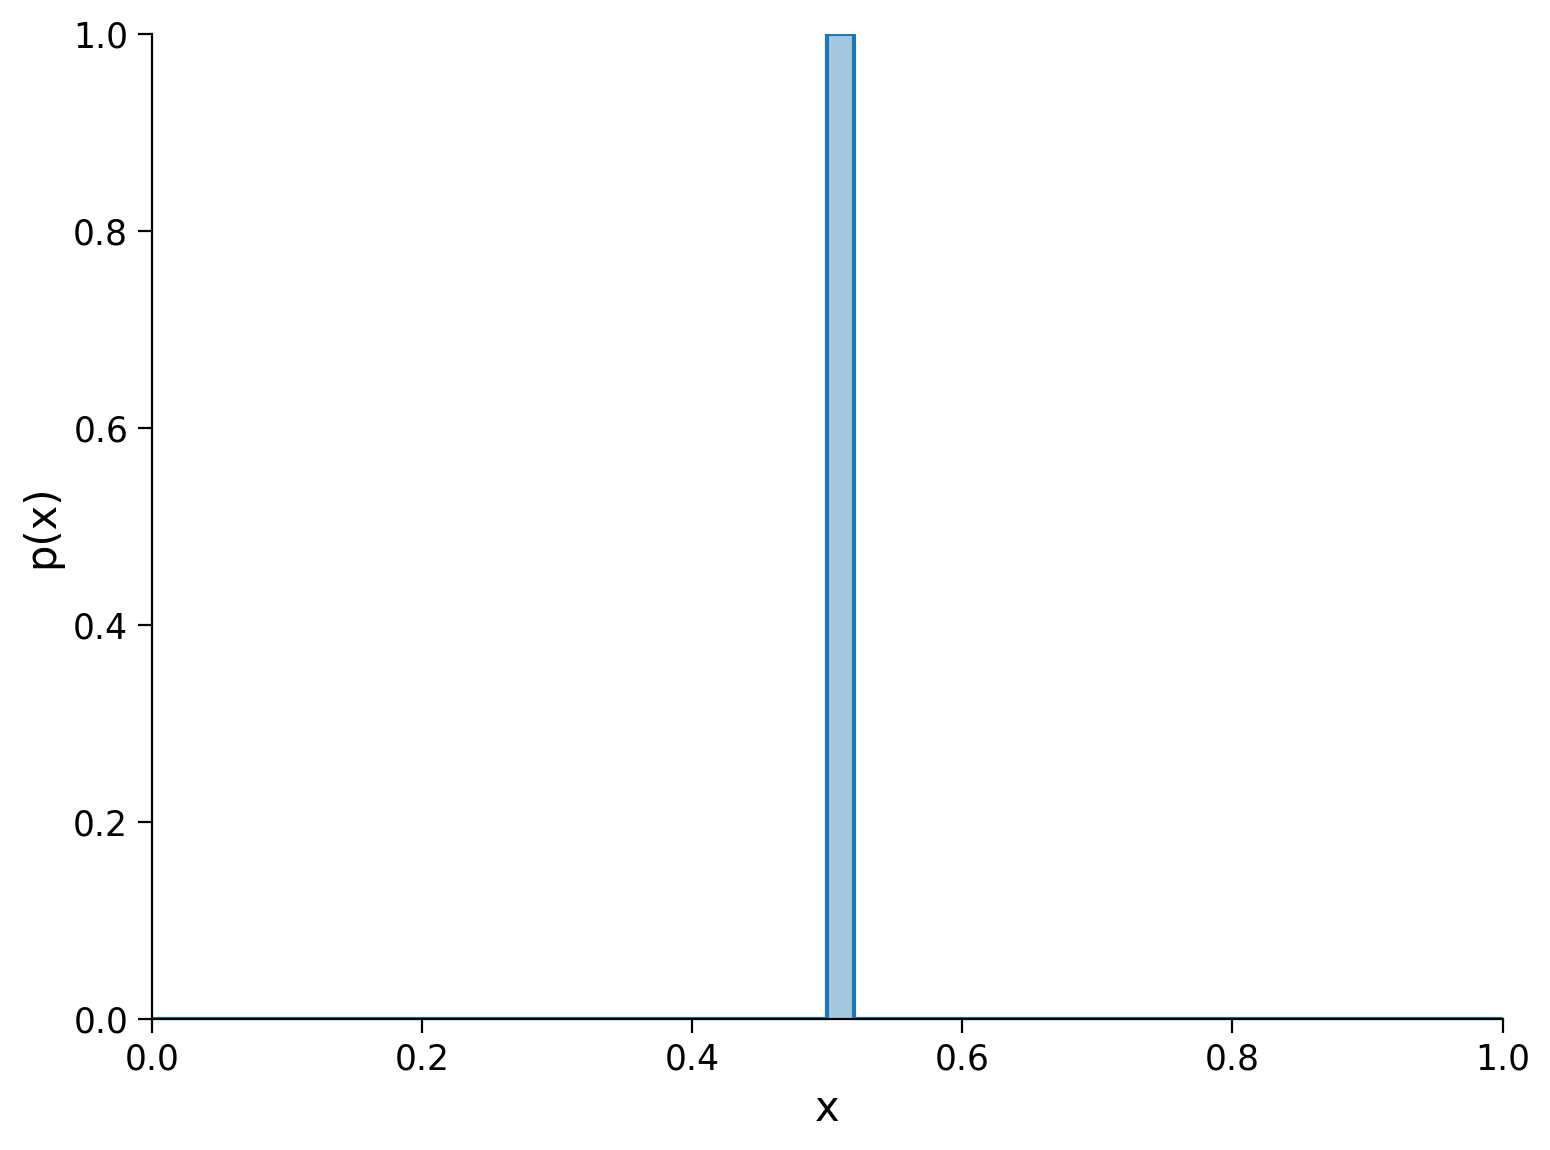

In [14]:
n_bins = 50  # number of points supporting the distribution
x_range = (0, 1)  # will be subdivided evenly into bins corresponding to points

bins = np.linspace(*x_range, n_bins + 1)  # bin edges

pmf = np.zeros(n_bins)
pmf[len(pmf) // 2] = 1.0  # middle point has all the mass

# Since we already have a PMF, rather than un-binned samples, `plt.hist` is not
# suitable. Instead, we directly plot the PMF as a step function to visualize
# the histogram:
pmf_ = np.insert(pmf, 0, pmf[0])  # this is necessary to align plot steps with bin edges
plt.plot(bins, pmf_, drawstyle="steps")
# `fill_between` provides area shading
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range)
plt.ylim(0, 1);

In [15]:
def entropy(pmf):
  """Given a discrete distribution, return the Shannon entropy in bits.

  This is a measure of information in the distribution. For a totally
  deterministic distribution, where samples are always found in the same bin,
  then samples from the distribution give no more information and the entropy
  is 0.

  For now this assumes `pmf` arrives as a well-formed distribution (that is,
  `np.sum(pmf)==1` and `not np.any(pmf < 0)`)

  Args:
    pmf (np.ndarray): The probability mass function for a discrete distribution
      represented as an array of probabilities.
  Returns:
    h (number): The entropy of the distribution in `pmf`.

  """
  ############################################################################
  # Exercise for students: compute the entropy of the provided PMF
  #   1. Exclude the points in the distribution with no mass (where `pmf==0`).
  #      Hint: this is equivalent to including only the points with `pmf>0`.
  #   2. Implement the equation for Shannon entropy (in bits).
  #  When ready to test, comment or remove the next line
 # raise NotImplementedError("Exercise: implement the equation for entropy")
  ############################################################################

  # reduce to non-zero entries to avoid an error from log2(0)
  pmf =  pmf[pmf > 0]

  # implement the equation for Shannon entropy (in bits)
  h = -np.sum(pmf * np.log2(pmf))

  # return the absolute value (avoids getting a -0 result)
  return np.abs(h)

# Call entropy function and print result
print(f"{entropy(pmf):.2f} bits")

0.00 bits


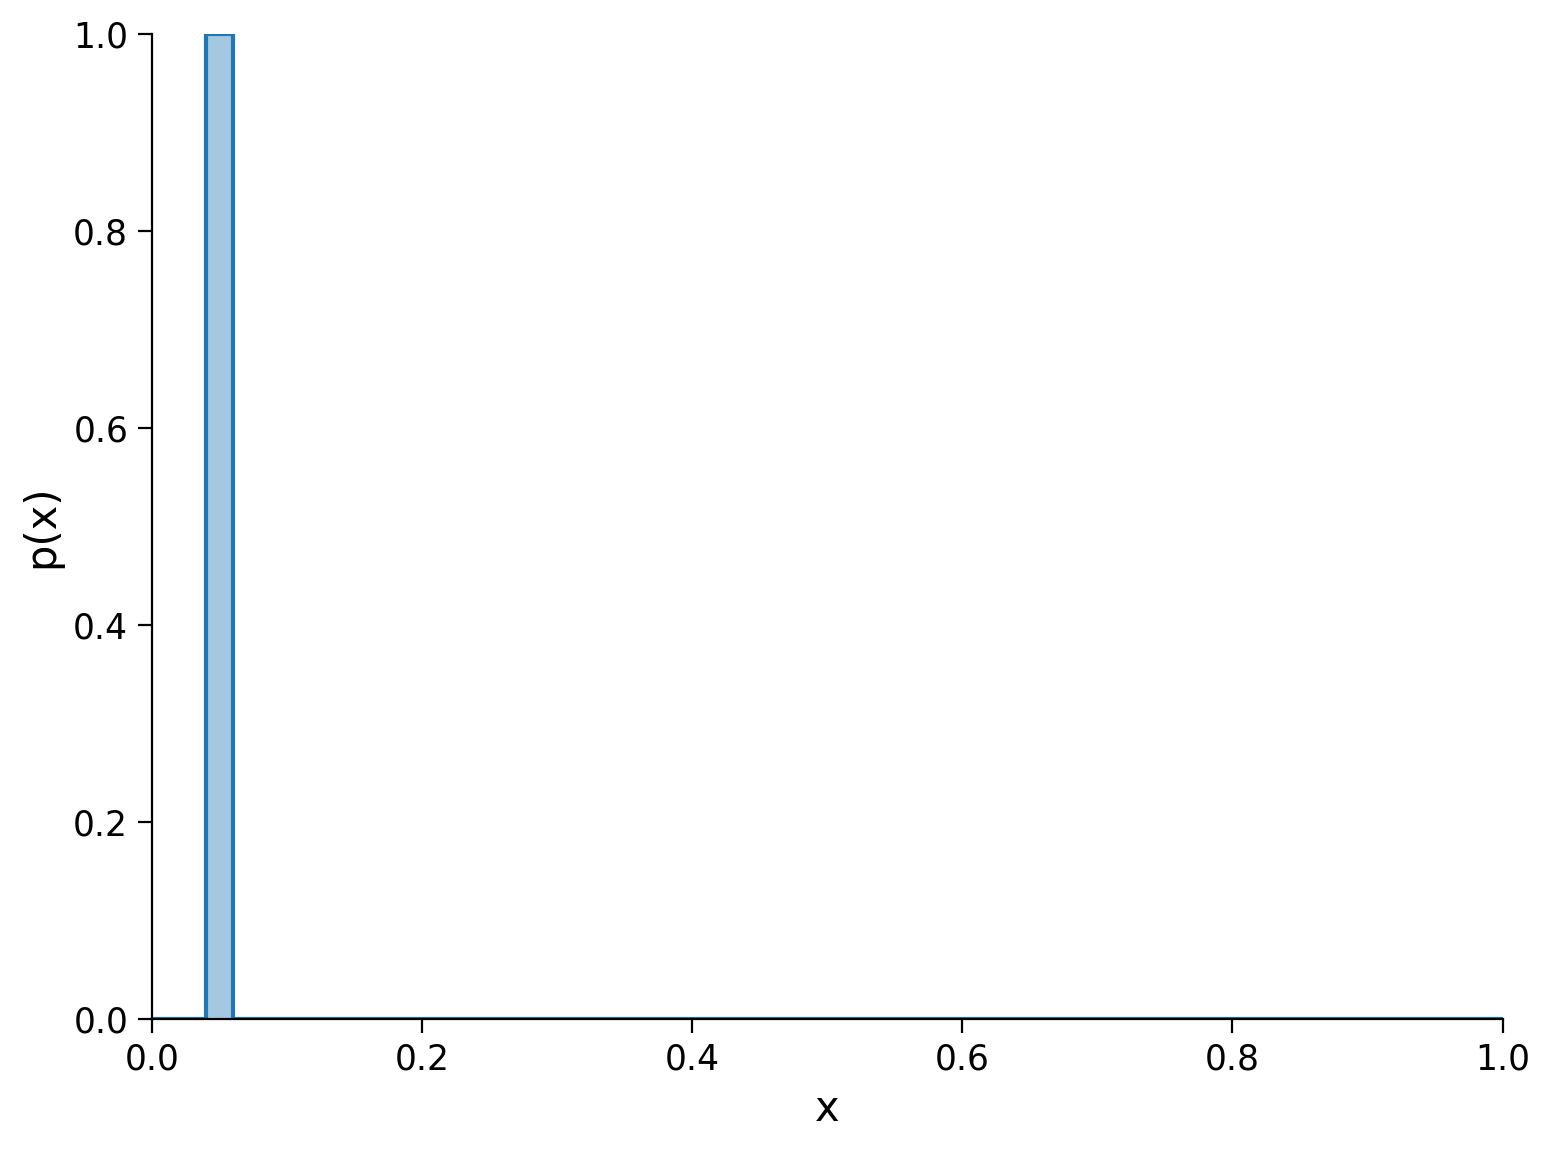

In [16]:
# @markdown Execute this cell to visualize another PMF with zero entropy
pmf = np.zeros(n_bins)
pmf[2] = 1.0  # arbitrary point has all the mass

pmf_ = np.insert(pmf, 0, pmf[0])
plt.plot(bins, pmf_, drawstyle="steps")
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range)
plt.ylim(0, 1);

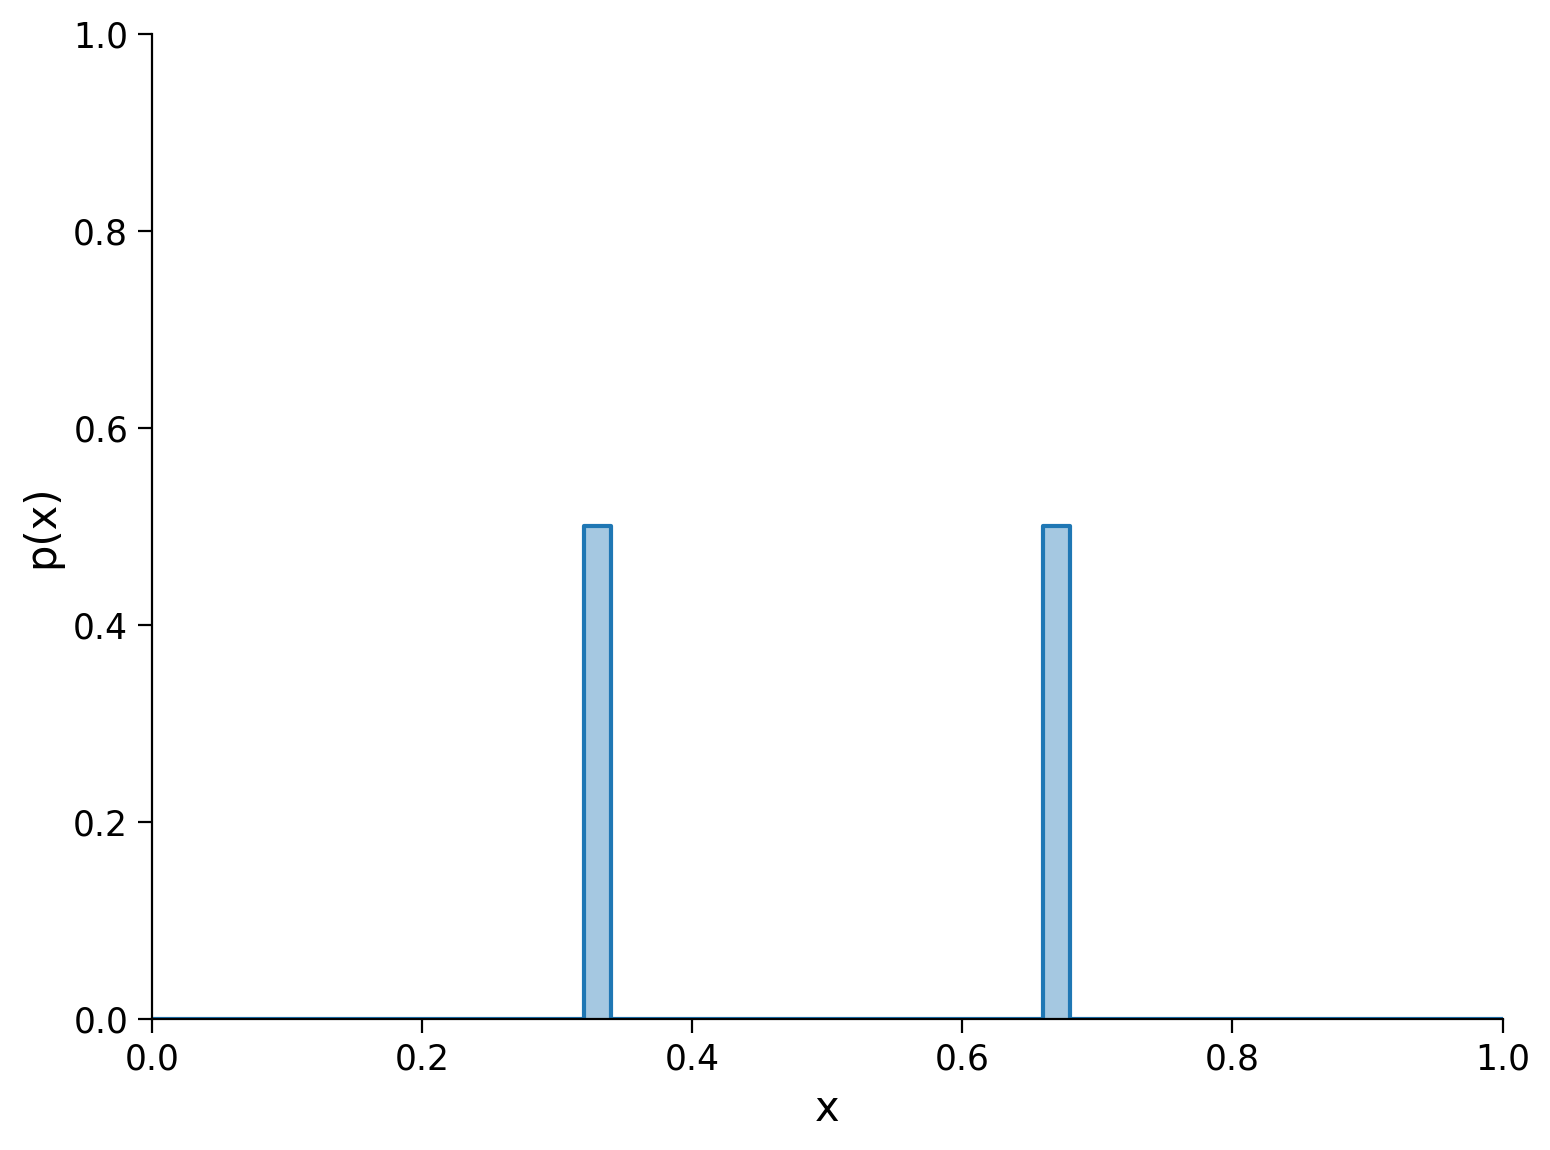

In [17]:
# @markdown Execute this cell to visualize a PMF with split mass

pmf = np.zeros(n_bins)
pmf[len(pmf) // 3] = 0.5
pmf[2 * len(pmf) // 3] = 0.5

pmf_ = np.insert(pmf, 0, pmf[0])
plt.plot(bins, pmf_, drawstyle="steps")
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range)
plt.ylim(0, 1);

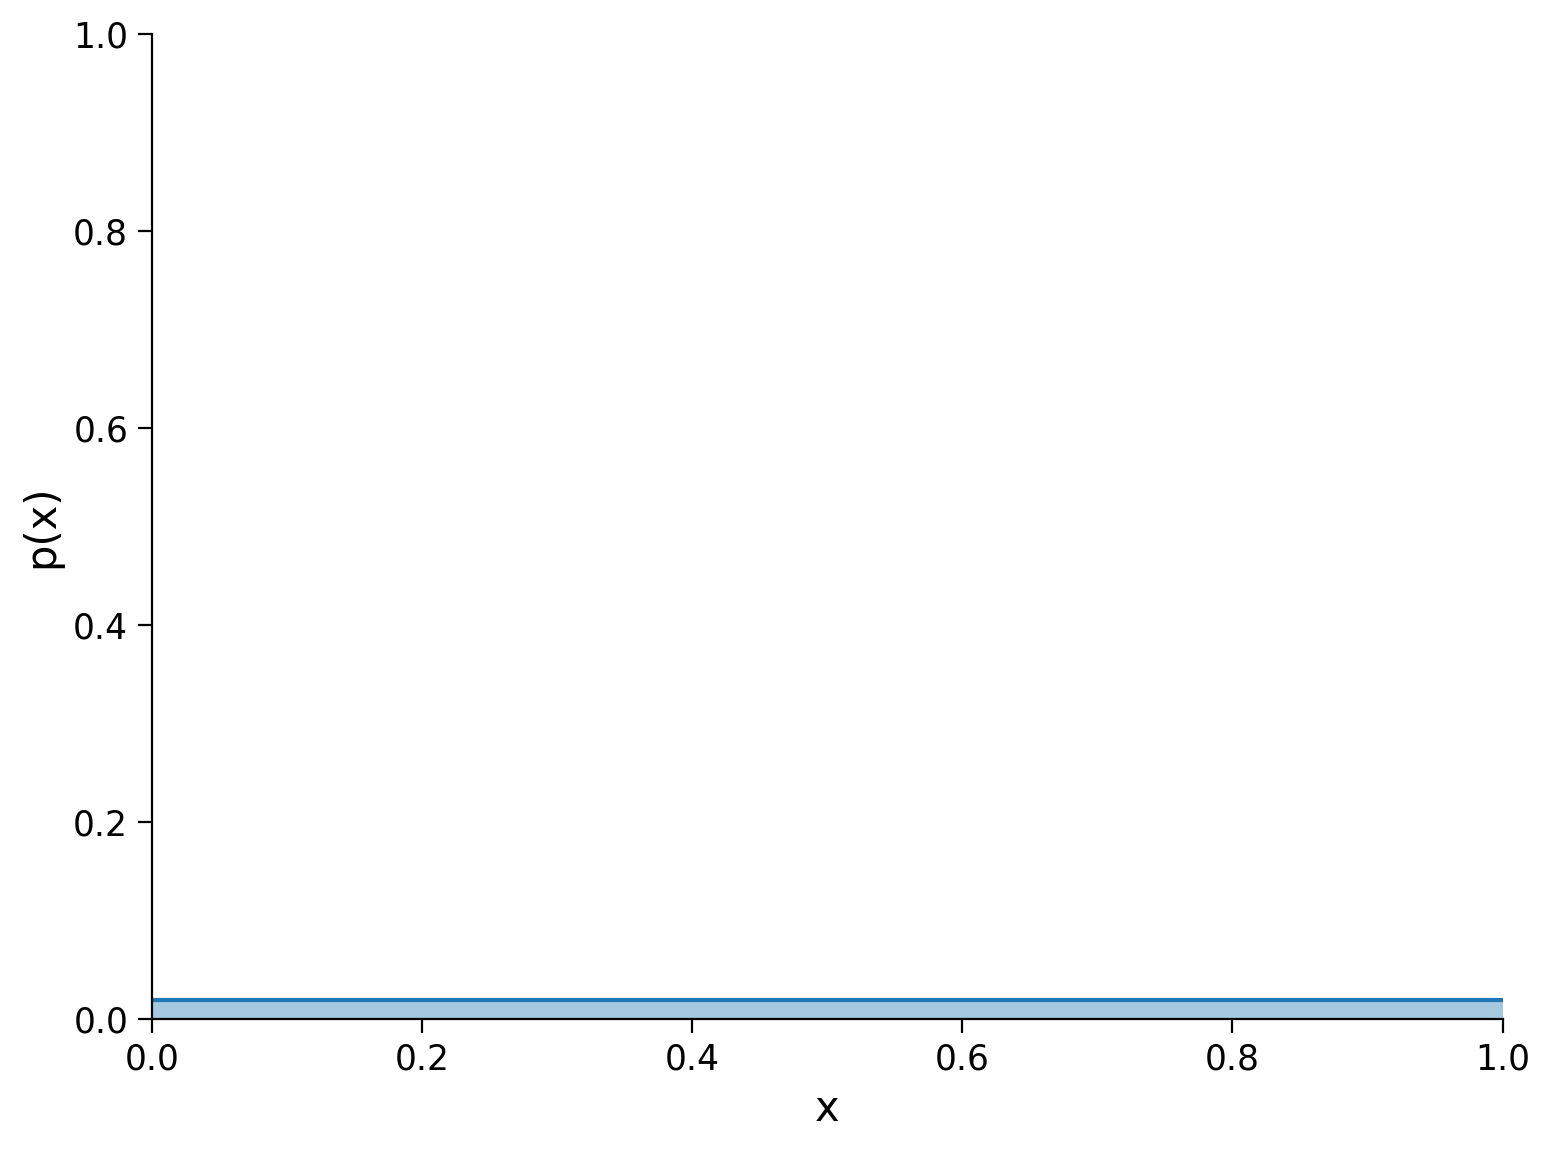

In [18]:
# @markdown Execute this cell to visualize a PMF of uniform distribution

pmf = np.ones(n_bins) / n_bins  # [1/N] * N

pmf_ = np.insert(pmf, 0, pmf[0])
plt.plot(bins, pmf_, drawstyle="steps")
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range);
plt.ylim(0, 1);

In [19]:
n_bins = 50
mean_isi = 0.025
isi_range = (0, 0.25)

bins = np.linspace(*isi_range, n_bins + 1)
mean_idx = np.searchsorted(bins, mean_isi)

# 1. all mass concentrated on the ISI mean
pmf_single = np.zeros(n_bins)
pmf_single[mean_idx] = 1.0

# 2. mass uniformly distributed about the ISI mean
pmf_uniform = np.zeros(n_bins)
pmf_uniform[0:2*mean_idx] = 1 / (2 * mean_idx)

# 3. mass exponentially distributed about the ISI mean
pmf_exp = stats.expon.pdf(bins[1:], scale=mean_isi)
pmf_exp /= np.sum(pmf_exp)

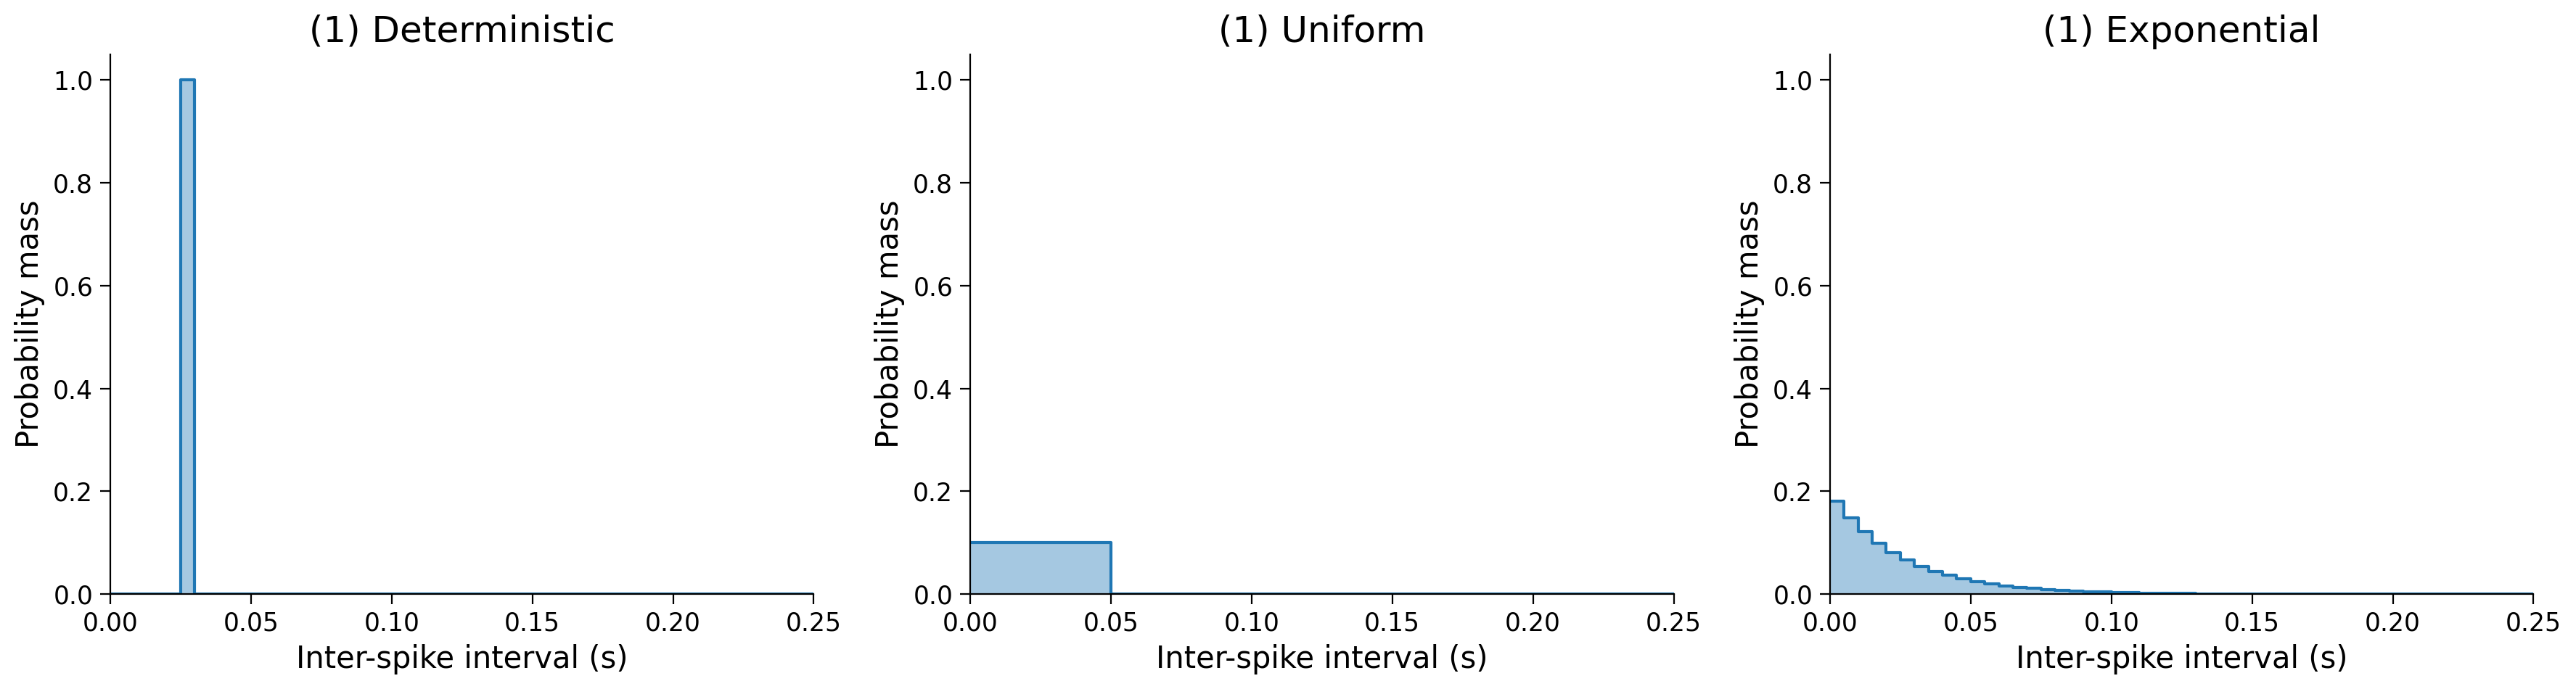

In [20]:
#@title
#@markdown Run this cell to plot the three PMFs
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

dists =  [# (subplot title, pmf, ylim)
          ("(1) Deterministic", pmf_single, (0, 1.05)),
          ("(1) Uniform", pmf_uniform, (0, 1.05)),
          ("(1) Exponential", pmf_exp, (0, 1.05))]

for ax, (label, pmf_, ylim) in zip(axes, dists):
  pmf_ = np.insert(pmf_, 0, pmf_[0])
  ax.plot(bins, pmf_, drawstyle="steps")
  ax.fill_between(bins, pmf_, step="pre", alpha=0.4)
  ax.set_title(label)
  ax.set_xlabel("Inter-spike interval (s)")
  ax.set_ylabel("Probability mass")
  ax.set_xlim(isi_range);
  ax.set_ylim(ylim);

In [21]:
print(
  f"Deterministic: {entropy(pmf_single):.2f} bits",
  f"Uniform: {entropy(pmf_uniform):.2f} bits",
  f"Exponential: {entropy(pmf_exp):.2f} bits",
  sep="\n",
)

Deterministic: 0.00 bits
Uniform: 3.32 bits
Exponential: 3.77 bits


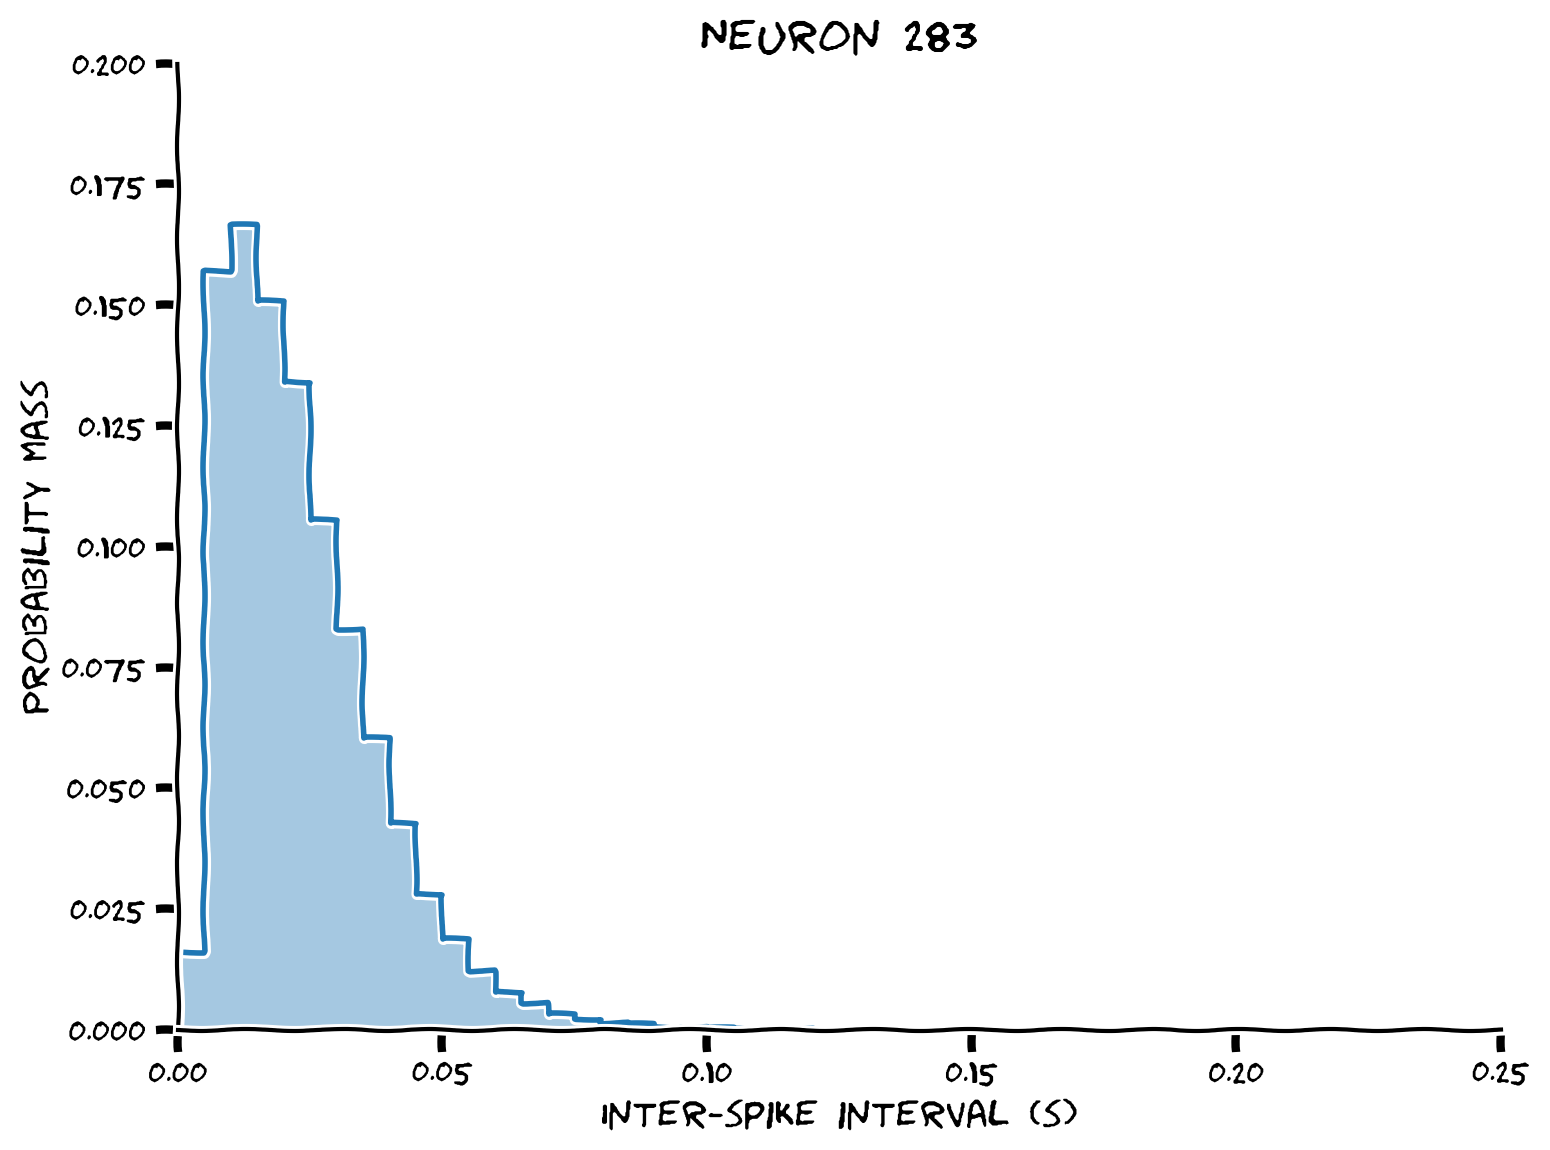

In [22]:
def pmf_from_counts(counts):
  """Given counts, normalize by the total to estimate probabilities."""
  ###########################################################################
  # Exercise: Compute the PMF. Remove the next line to test your function
  #raise NotImplementedError("Student exercise: compute the PMF from ISI counts")
  ###########################################################################

  pmf =  counts / np.sum(counts)

  return pmf


# Get neuron index
neuron_idx = 283

# Get counts of ISIs from Steinmetz data
isi = np.diff(steinmetz_spikes[neuron_idx])
bins = np.linspace(*isi_range, n_bins + 1)
counts, _ = np.histogram(isi, bins)

# Compute pmf
pmf = pmf_from_counts(counts)

# Visualize
with plt.xkcd():
 plot_pmf(pmf,isi_range)

In [23]:
print(f"Entropy for Neuron {neuron_idx}: {entropy(pmf):.2f} bits")

Entropy for Neuron 283: 3.36 bits


interactive(children=(IntSlider(value=0, description='neuron', max=733), Output()), _dom_classes=('widget-inte…

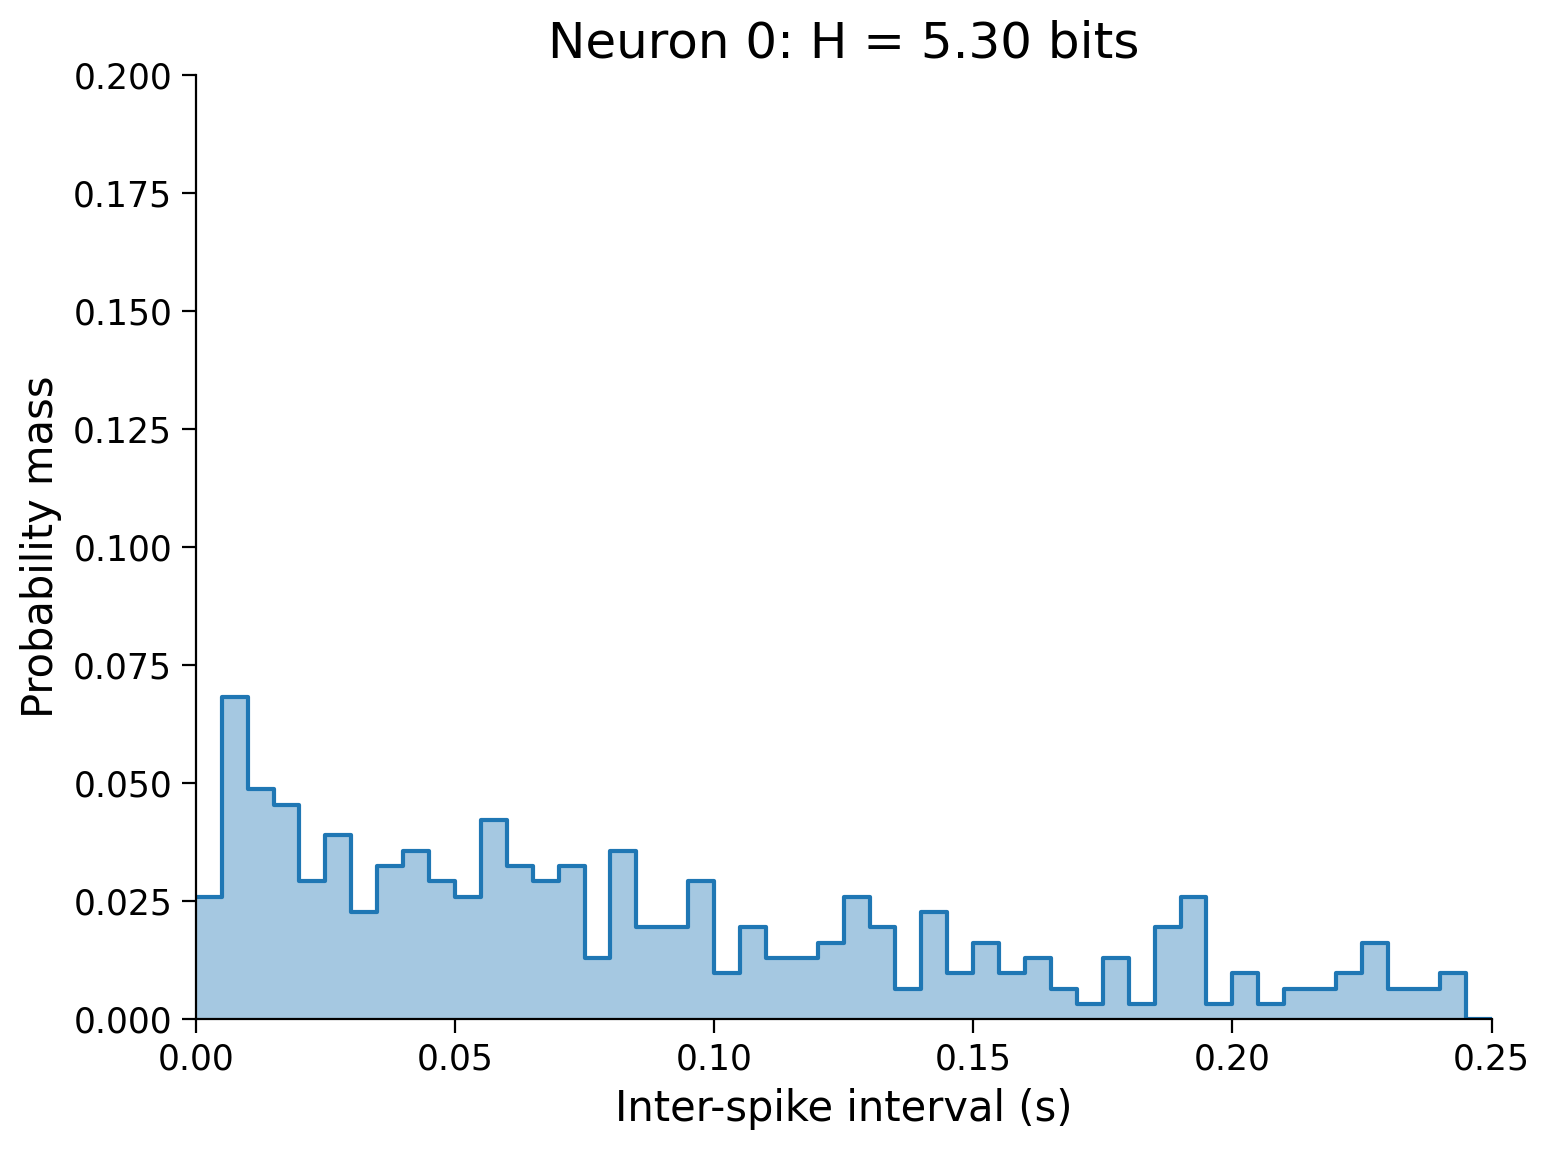

In [24]:
#@title
#@markdown **Run the cell** to enable the sliders.

def _pmf_from_counts(counts):
  """Given counts, normalize by the total to estimate probabilities."""
  pmf = counts / np.sum(counts)
  return pmf

def _entropy(pmf):
  """Given a discrete distribution, return the Shannon entropy in bits."""
  # remove non-zero entries to avoid an error from log2(0)
  pmf = pmf[pmf > 0]
  h = -np.sum(pmf * np.log2(pmf))
  # absolute value applied to avoid getting a -0 result
  return np.abs(h)

@widgets.interact(neuron=widgets.IntSlider(0, min=0, max=(len(steinmetz_spikes)-1)))
def steinmetz_pmf(neuron):
  """ Given a neuron from the Steinmetz data, compute its PMF and entropy """
  isi = np.diff(steinmetz_spikes[neuron])
  bins = np.linspace(*isi_range, n_bins + 1)
  counts, _ = np.histogram(isi, bins)
  pmf = _pmf_from_counts(counts)

  plot_pmf(pmf,isi_range)
  plt.title(f"Neuron {neuron}: H = {_entropy(pmf):.2f} bits")

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# for random distributions:
from scipy.stats import norm, poisson

# for logistic regression:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [2]:
# @title Plotting Functions

def rasterplot(spikes,movement,trial):

  [movements, trials, neurons, timepoints] = np.shape(spikes)

  trial_spikes = spikes[movement,trial,:,:]

  trial_events = [((trial_spikes[x,:] > 0).nonzero()[0]-150)/100 for x in range(neurons)]

  plt.figure()
  dt=1/100
  plt.eventplot(trial_events, linewidths=1);
  plt.title('movement: %d - trial: %d'%(movement, trial))
  plt.ylabel('neuron')
  plt.xlabel('time [s]')

def plotCrossValAccuracies(accuracies):
  f, ax = plt.subplots(figsize=(8, 3))
  ax.boxplot(accuracies, vert=False, widths=.7)
  ax.scatter(accuracies, np.ones(8))
  ax.set(
    xlabel="Accuracy",
    yticks=[],
    title=f"Average test accuracy: {accuracies.mean():.2%}"
  )
  ax.spines["left"].set_visible(False)

In [3]:
#@title Generate Data

def generateSpikeTrains():

  gain        = 2
  neurons     = 50
  movements   = [0,1,2]
  repetitions = 800

  np.random.seed(37)

  # set up the basic parameters:
  dt = 1/100
  start, stop = -1.5, 1.5
  t = np.arange(start, stop+dt, dt)                                            # a time interval
  Velocity_sigma = 0.5                                                         # std dev of the velocity profile
  Velocity_Profile = norm.pdf(t,0,Velocity_sigma)/norm.pdf(0,0,Velocity_sigma) # The Gaussian velocity profile, normalized to a peak of 1

  # set up the neuron properties:
  Gains = np.random.rand(neurons) * gain          # random sensitivity between 0 and `gain`
  FRs   = (np.random.rand(neurons) * 60 ) - 10    # random base firing rate between -10 and 50

  # output matrix will have this shape:
  target_shape = [len(movements), repetitions, neurons, len(Velocity_Profile)]

  # build matrix for spikes, first, they depend on the velocity profile:
  Spikes = np.repeat(Velocity_Profile.reshape([1,1,1,len(Velocity_Profile)]),len(movements)*repetitions*neurons,axis=2).reshape(target_shape)

  # multiplied by gains:
  S_gains = np.repeat(np.repeat(Gains.reshape([1,1,neurons]), len(movements)*repetitions, axis=1).reshape(target_shape[:3]), len(Velocity_Profile)).reshape(target_shape)
  Spikes = Spikes * S_gains

  # and multiplied by the movement:
  S_moves = np.repeat( np.array(movements).reshape([len(movements),1,1,1]), repetitions*neurons*len(Velocity_Profile), axis=3 ).reshape(target_shape)
  Spikes = Spikes * S_moves

  # on top of a baseline firing rate:
  S_FR = np.repeat(np.repeat(FRs.reshape([1,1,neurons]), len(movements)*repetitions, axis=1).reshape(target_shape[:3]), len(Velocity_Profile)).reshape(target_shape)
  Spikes = Spikes + S_FR

  # can not run the poisson random number generator on input lower than 0:
  Spikes = np.where(Spikes < 0, 0, Spikes)

  # so far, these were expected firing rates per second, correct for dt:
  Spikes = poisson.rvs(Spikes * dt)

  return(Spikes)


def subsetPerception(spikes):

  movements = [0,1,2]
  split     = 400
  subset    = 40
  hwin      = 3

  [num_movements, repetitions, neurons, timepoints] = np.shape(spikes)

  decision = np.zeros([num_movements, repetitions])

  # ground truth for logistic regression:
  y_train = np.repeat([0,1,1],split)
  y_test  = np.repeat([0,1,1],repetitions-split)

  m_train = np.repeat(movements, split)
  m_test  = np.repeat(movements, split)

  # reproduce the time points:
  dt = 1/100
  start, stop = -1.5, 1.5
  t = np.arange(start, stop+dt, dt)

  w_idx = list( (abs(t) < (hwin*dt)).nonzero()[0] )
  w_0 = min(w_idx)
  w_1 = max(w_idx)+1  # python...

  # get the total spike counts from stationary and movement trials:
  spikes_stat = np.sum( spikes[0,:,:,:], axis=2)
  spikes_move = np.sum( spikes[1:,:,:,:], axis=3)

  train_spikes_stat = spikes_stat[:split,:]
  train_spikes_move = spikes_move[:,:split,:].reshape([-1,neurons])

  test_spikes_stat = spikes_stat[split:,:]
  test_spikes_move = spikes_move[:,split:,:].reshape([-1,neurons])

  # data to use to predict y:
  x_train = np.concatenate((train_spikes_stat, train_spikes_move))
  x_test  = np.concatenate(( test_spikes_stat,  test_spikes_move))

  # this line creates a logistics regression model object, and immediately fits it:
  population_model = LogisticRegression(solver='liblinear', random_state=0).fit(x_train, y_train)

  # solver, one of: 'liblinear', 'newton-cg', 'lbfgs', 'sag', and 'saga'
  # some of those require certain other options
  #print(population_model.coef_)       # slope
  #print(population_model.intercept_)  # intercept

  ground_truth = np.array(population_model.predict(x_test))
  ground_truth = ground_truth.reshape([3,-1])

  output = {}
  output['perception'] = ground_truth
  output['spikes']     = spikes[:,split:,:subset,:]

  return(output)


def getData():

  spikes = generateSpikeTrains()

  dataset = subsetPerception(spikes=spikes)

  return(dataset)

dataset = getData()
perception = dataset['perception']
spikes = dataset['spikes']

In [4]:
# @title Example projects step 1
from ipywidgets import widgets
from IPython.display import Markdown

markdown1 = '''

## Step 1
<br>
<font size='3pt'>
The train illusion occurs when sitting on a train and viewing another train outside the window. Suddenly, the other train *seems* to move, i.e. you experience visual motion of the other train relative to your train. But which train is actually moving?

Often people have the wrong percept. In particular, they think their own train might be moving when it's the other train that moves; or vice versa. The illusion is usually resolved once you gain vision of the surroundings that lets you disambiguate the relative motion; or if you experience strong vibrations indicating that it is indeed your own train that is in motion.


We asked the following (arbitrary) question for our demo project: "How do noisy vestibular estimates of motion lead to illusory percepts of self motion?"
</font>
'''

markdown2 = '''
## Step 1
<br>

<font size='3pt'>
The train illusion occurs when sitting on a train and viewing another train outside the window. Suddenly, the other train *seems* to move, i.e. you experience visual motion of the other train relative to your train. But which train is actually moving?

Often people mix this up. In particular, they think their own train might be moving when it's the other train that moves; or vice versa. The illusion is usually resolved once you gain vision of the surroundings that lets you disambiguate the relative motion; or if you experience strong vibrations indicating that it is indeed your own train that is in motion.


We assume that we have build the train illusion model (see the other example project colab). That model predicts that accumulated sensory evidence from vestibular signals determines the decision of whether self-motion is experienced or not. We now have vestibular neuron data (simulated in our case, but let's pretend) and would like to see if that prediction holds true.

The data contains *N* neurons and *M* trials for each of 3 motion conditions: no self-motion, slowly accelerating self-motion and faster accelerating self-motion. In our data,
*N* = 40 and *M* = 400.

**So we can ask the following question**: "Does accumulated vestibular neuron activity correlate with self-motion judgements?"
</font>
'''

out2 = widgets.Output()
with out2:
  display(Markdown(markdown2))

out1 = widgets.Output()
with out1:
  display(Markdown(markdown1))

out = widgets.Tab([out1, out2])
out.set_title(0, 'Computational Model')
out.set_title(1, 'Data Analysis')

display(out)

In [5]:
# @title Example projects step 2
from ipywidgets import widgets
from IPython.display import Markdown

markdown1 = '''

## Step 2

<br>
<font size='3pt'>

You have learned all about the vestibular system in the Intro video. This is also where you would do a literature search to learn more about what's known about self-motion perception and vestibular signals. You would also want to examine any attempts to model self-motion, perceptual decision making and vestibular processing.</font>
'''

markdown21 = '''
## Step 2

<br>
<font size='3pt'>
While it seems a well-known fact that vestibular signals are noisy, we should check if we can also find this in the literature.

Let's also see what's in our data, there should be a 4d array called `spikes` that has spike counts (positive integers), a 2d array called `perception` with self-motion judgements (0=no motion or 1=motion). Let's see what this data looks like:

</font><br>
'''

markdown22 = '''
<br>
<font size='3pt'>
In the `spikes` array, we see our 3 acceleration conditions (first dimension), with 400 trials each (second dimensions) and simultaneous recordings from 40 neurons (third dimension), across 3 seconds in 10 ms bins (fourth dimension). The first two dimensions are also there in the `perception` array.

Perfect perception would have looked like [0, 1, 1]. The average judgements are far from correct (lots of self-motion illusions) but they do make some sense: it's closer to 0 in the no-motion condition and closer to 1 in both of the real-motion conditions.

The idea of our project is that the vestibular signals are noisy so that they might be mis-interpreted by the brain. Let's see if we can reproduce the stimuli from the data:
</font>
<br>
'''

markdown23 = '''
<br>
<font size='3pt'>
Blue is the no-motion condition, and produces flat average spike counts across the 3 s time interval. The orange and green line do show a bell-shaped curve that corresponds to the acceleration profile. But there also seems to be considerable noise: exactly what we need. Let's see what the spike trains for a single trial look like:
</font>
<br>
'''

markdown24 = '''
<br>
<font size='3pt'>
You can change the trial number in the bit of code above to compare what the rasterplots look like in different trials. You'll notice that they all look kind of the same: the 3 conditions are very hard (impossible?) to distinguish by eye-balling.

Now that we have seen the data, let's see if we can extract self-motion judgements from the spike counts.
</font>
<br>
'''

display(Markdown(r""))

out2 = widgets.Output()
with out2:
  display(Markdown(markdown21))
  print(f'The shape of `spikes` is: {np.shape(spikes)}')
  print(f'The shape of `perception` is: {np.shape(perception)}')
  print(f'The mean of `perception` is: {np.mean(perception, axis=1)}')
  display(Markdown(markdown22))

  for move_no in range(3):
    plt.plot(np.arange(-1.5,1.5+(1/100),(1/100)),np.mean(np.mean(spikes[move_no,:,:,:], axis=0), axis=0), label=['no motion', '$1 m/s^2$', '$2 m/s^2$'][move_no])
  plt.xlabel('time [s]');
  plt.ylabel('averaged spike counts');
  plt.legend()
  plt.show()

  display(Markdown(markdown23))

  for move in range(3):
    rasterplot(spikes = spikes, movement = move, trial = 0)
  plt.show()

  display(Markdown(markdown24))

out1 = widgets.Output()
with out1:
  display(Markdown(markdown1))

out = widgets.Tab([out1, out2])
out.set_title(0, 'Computational Model')
out.set_title(1, 'Data Analysis')

display(out)

In [6]:
# @title Example projects step 3
from ipywidgets import widgets
from IPython.display import Markdown, Math

markdown1 = r'''

## Step 3
<br>
<font size='3pt'>
We determined that we probably needed the following ingredients for our model:

* Vestibular input: *v(t)*

* Binary decision output: *d* - time dependent?

* Decision threshold: θ

* A filter (maybe running average?): *f*

* An integration mechanism to get from vestibular acceleration to sensed velocity: ∫

</font>
'''

markdown2 = '''
## Step 3
<br>
<font size='3pt'>
In order to address our question we need to design an appropriate computational data analysis pipeline. We did some brainstorming and think that we need to somehow extract the self-motion judgements from the spike counts of our neurons. Based on that, our algorithm needs to make a decision: was there self motion or not? This is a classical 2-choice classification problem. We will have to transform the raw spike data into the right input for the algorithm (spike pre-processing).

So we determined that we probably needed the following ingredients:

* spike trains *S* of 3-second trials (10ms spike bins)
* ground truth movement *m<sub>r</sub>* (real) and perceived movement *m<sub>p</sub>*
* some form of classifier *C* giving us a classification *c*
* spike pre-processing
</font>
'''

# No idea why this is necessary but math doesn't render properly without it
display(Markdown(r""))


out2 = widgets.Output()
with out2:
  display(Markdown(markdown2))


out1 = widgets.Output()
with out1:
  display(Markdown(markdown1))

out = widgets.Tab([out1, out2])
out.set_title(0, 'Computational Model')
out.set_title(1, 'Data Analysis')

display(out)

In [7]:
# @title Example projects step 4
from ipywidgets import widgets
from IPython.display import Markdown

# Not writing in latex because that didn't render in jupyterbook

markdown1 = r'''

## Step 4
<br>
<font size='3pt'>
Our main hypothesis is that the strength of the illusion has a linear relationship to the amplitude of vestibular noise.

Mathematically, this would write as

<div align="center">
<em>S</em> = <em>k</em> ⋅ <em>N</em>
</div>

where *S* is the illusion strength and *N* is the noise level, and *k* is a free parameter.
>we could simply use the frequency of occurance across repetitions as the "strength of the illusion"

We would get the noise as the standard deviation of *v(t)*, i.e.

<div align="center">
<em>N</em> = <b>E</b>[<em>v(t)</em><sup>2</sup>],
</div>

 where **E** stands for the expected value.

Do we need to take the average across time points?
> doesn't really matter because we have the generative process, so we can just use the σ that we define
</font>
'''

markdown2 = '''
## Step 4
<br>

<font size='3pt'>
We think that noise in the signal drives whether or not people perceive self motion. Maybe the brain uses the strongest signal at peak acceleration to decide on self motion, but we actually think it is better to accumulate evidence over some period of time. We want to test this. The noise idea also means that when the signal-to-noise ratio is higher, the brain does better, and this would be in the faster acceleration condition. We want to test this too.

We came up with the following hypotheses focussing on specific details of our overall research question:

* Hyp 1: Accumulated vestibular spike rates explain self-motion judgements better than average spike rates around peak acceleration.
* Hyp 2: Classification performance should be better for faster vs slower self-motion.

> There are many other hypotheses you could come up with, but for simplicity, let's go with those.

Mathematically, we can write our hypotheses as follows (using our above ingredients):
* Hyp 1: **E**(c<sub>accum</sub>) > **E**(c<sub>win</sub>)
* Hyp 2: **E**(c<sub>fast</sub>) > **E**(c<sub>slow</sub>)

Where **E** denotes taking the expected value (in this case the mean) of its argument: classification outcome in a given trial type.
</font>
'''

# No idea why this is necessary but math doesn't render properly without it
display(Markdown(r""))

out2 = widgets.Output()
with out2:
  display(Markdown(markdown2))

out1 = widgets.Output()
with out1:
  display(Markdown(markdown1))

out = widgets.Tab([out1, out2])
out.set_title(0, 'Computational Model')
out.set_title(1, 'Data Analysis')

display(out)